2018 Edition

# Building a music recommender system

As its name implies, a recommender system is a tool that helps predicting what a user may or may not like among a list of given items. In some sense, you can view this as an alternative to content search, as recommendation engines help users discover products or content that they may not come across otherwise. For example, Facebook suggests friends and pages to users. Youtube recommends videos which users may be interested in. Amazon suggests the products which users may need... Recommendation engines engage users to services, can be seen as a revenue optimization process, and in general help maintaining interest in a service.

In this notebook, we study how to build a simple recommender system: we focus on music recommendations, and we use a simple algorithm to predict which items users might like, that is called ALS, alternating least squares.

## Goals

In this lecture, we expect students to:

- Revisit (or learn) recommender algorithms

- Understand the idea of Matrix Factorization and the ALS algorithm (serial and parallel versions)

- Build a simple model for a real usecase: music recommender system

- Understand how to validate the results

## Steps

We assume students to work outside lab hours on the learning material. These are the steps by which we guide students, during labs, to build a good basis for the end-to-end development of a recommender system:

* Inspect the data using Spark SQL, and build some basic, but very valuable knowledge about the information we have at hand
* Formally define what is a sensible algorithm to achieve our goal: given the "history" of user taste for music, recommend new music to discover. Essentialy, we want to build a statistical model of user preferences such that we can use it to "predict" which additional music the user could like
* With our formal definition at hand, we will learn different ways to implement such an algorithm. Our goal here is to illustrate what are the difficulties to overcome when implementing a (parallel) algorithm
* Finally, we will focus on an existing implementation, available in the Apache Spark MLLib, which we will use out of the box to build a reliable statistical model

Now, you may think at this point we will be done!

Well, you'd better think twice: one important topic we will cover in all our Notebooks is **how to validate the results we obtain**, and **how to choose good parameters to train models** especially when using an "opaque" library for doing the job. As a consequence, we will focus on the statistical validation of our recommender system.


# 1. Data

Understanding data is one of the most important part when designing any machine learning algorithm. In this notebook, we will use a data set published by Audioscrobbler - a music recommendation system for last.fm. Audioscrobbler is also one of the first internet streaming radio sites, founded in 2002. It provided an open API for “scrobbling”, or recording listeners’ plays of artists’ songs. last.fm used this information to build a powerful music recommender engine.

## 1.1. Data schema

Unlike a rating dataset which contains information about users' preference for products (one star, 3 stars, and so on), the datasets from Audioscrobbler only has information about events: specifically, it keeps track of how many times a user played songs of a given artist and the names of artists. That means it carries less information than a rating: in the literature, this is called explicit vs. implicit ratings.

### Reading material

- [Implicit Feedback for Inferring User Preference: A Bibliography](http://people.csail.mit.edu/teevan/work/publications/papers/sigir-forum03.pdf)
- [Comparing explicit and implicit feedback techniques for web retrieval: TREC-10 interactive track report](http://trec.nist.gov/pubs/trec10/papers/glasgow.pdf)
- [Probabilistic Models for Data Combination in Recommender Systems](http://mlg.eng.cam.ac.uk/pub/pdf/WilGha08.pdf)

The data we use in this Notebook is available in 3 files (these files are stored in our HDFS layer, in the directory  ```/datasets/lastfm```):

- **`user_artist_data.txt`**: It contains about 140,000+ unique users, and 1.6 million unique artists. About 24.2 million users’ plays of artists’ are recorded, along with their count. It has 3 columns separated by spaces: 

| UserID | ArtistID | PlayCount |
|----|----|----|
| ...|...|...|


- **`artist_data.txt`** : It prodives the names of each artist by their IDs. It has 2 columns separated by tab characters (`\t`).

| ArtistID | Name |
|---|---|
|...|...|

- **`artist_alias.txt`**: Note that when plays are scrobbled, the client application submits the name of the artist being played. This name could be misspelled or nonstandard. For example, "The Smiths", "Smiths, The", and "the smiths" may appear as distinct artist IDs in the data set, even though they are plainly the same. `artist_alias.txt` maps artist IDs that are known misspellings or variants to the canonical ID of that artist. The data in this file has 2 columns separated by tab characters (`\t`).

| MisspelledArtistID | StandardArtistID |
|---|---|
|...|...|



## 1.2. Understanding data: simple descriptive statistic

In order to choose or design a suitable algorithm for achieving our goals, given the data we have, we should first understand data characteristics. To start, we import the necessary packages to work with regular expressions, Data Frames, and other nice features of our programming environment.

In [1]:
import os
import sys
import re
import random
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
from time import time
from IPython.display import display, HTML
from copy import deepcopy
#from matplotlib_venn import venn2

sqlContext = SQLContext(sc)
base = "/datasets/lastfm/"

# UTILITY METHOD TO DISPLAY DATAFRAME IN A "BEAUTIFUL" SCHEMA TABLE
def displayDF(dataframe, header):
    dataframe.columns = header
    display(HTML(dataframe.to_html(index=False)))
    print()

### Question 1

#### Question 1.0 (Non-grading)
<div class="alert alert-info">
Using SPARK SQL, load data from `/datasets/lastfm/user_artist_data.txt` and show the first 20 entries (via function `show()`).
</div>

For this Notebook, from a programming point of view, we are given the schema for the data we use, which is as follows:

```
userID: long int
artistID: long int
playCount: int
```

Each line of the dataset contains the above three fields, separated by a "white space".

In [99]:
userArtistDataSchema = StructType([ \
    StructField("userID", LongType(), True), \
    StructField("artistID", LongType(), True), \
    StructField("playCount", IntegerType(), True)])

userArtistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter=' ') \
    .load(base + "user_artist_data.txt", schema = userArtistDataSchema) \
    .cache()

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
userArtistDF.cache()

userArtistDF.show()

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
|1000002| 1000013|        8|
|1000002| 1000014|       42|
|1000002| 1000017|       69|
|1000002| 1000024|      329|
|1000002| 1000025|        1|
|1000002| 1000028|       17|
|1000002| 1000031|       47|
|1000002| 1000033|       15|
|1000002| 1000042|        1|
|1000002| 1000045|        1|
|1000002| 1000054|        2|
|1000002| 1000055|       25|
|1000002| 1000056|        4|
|1000002| 1000059|        2|
|1000002| 1000062|       71|
+-------+--------+---------+
only showing top 20 rows



#### Question 1.1: 
<div class="alert alert-info">
How many distinct users do we have in our data? 
</div>

In [100]:
uniqueUsers = userArtistDF \
    .select('userID') \
    .distinct() \
    .count()

print("Total n. of users: ", uniqueUsers)

Total n. of users:  148111


<div class="alert alert-success">
As we can see from the count computation (of distinct users) we get about 150000 users.
</div>

#### Question 1.2
<div class="alert alert-info">
How many distinct artists do we have in our data ?
</div>

In [101]:
uniqueArtists = userArtistDF \
    .select('artistID') \
    .distinct().count()

print("Total n. of artists: ", uniqueArtists)

Total n. of artists:  1631028


<div class="alert alert-success">
The different artists in the datasets are about 1600000.
Just for comparison: we have ~10^5 users and ~10^6 artists.
</div>

#### Question 1.3
<div class="alert alert-info">
One limitation of Spark MLlib's ALS implementation - which we will use later - is that it requires IDs for users and items to be nonnegative 32-bit integers. This means that IDs larger than `Integer.MAX_VALUE`, or `2147483647`, can't be used. So we need to check whether this data set conforms to the strict requirements of our library.  

What are the maximum and minimum values of column `userID` ?  
</div>

In [102]:
minMaxUserID = userArtistDF.select(min('userID'), max('userID'))
    
displayDF(minMaxUserID.toPandas(), ["min(UserID)", "max(UserID)"])

min(UserID),max(UserID)
90,2443548


<div class="alert alert-success">
From the computation of the minimum and maximum values of the userID, we are sure that the range is compatible with the Spark MLlib limitations. Indeed, the minimum value is non-negative, and the maximum value is below the 'Integer.MAX_VALUE' constant.
</div>

#### Question 1.4
<div class="alert alert-info">
What is the maximum and minimum values of column `artistID` ?
</div>

In [103]:
minMaxArtistID = userArtistDF.select(min('artistID'), max('artistID')) 

displayDF(minMaxArtistID.toPandas(), ["min(ArtistID)", "max(ArtistID)"])

min(ArtistID),max(ArtistID)
1,10794401


<div class="alert alert-success">
Similarly to the previous result, the range of values of the artistID is also compatible with the limitations of MLlib.
</div>

We just discovered that we have a total of 148,111 users in our dataset. Similarly, we have a total of 1,631,028 artists in our dataset. The maximum values of `userID` and `artistID` are still smaller than the biggest number of integer type.  No additional transformation will be necessary to use these IDs.

One thing we can see here is that SPARK SQL provides very concise and powerful methods for data analytics (compared to using RDD and their low-level API). You can see more examples [here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html).

<div class="alert alert-success">
We've computed some statistics, but we'll see later that they are "conditioned" by some issues, like mispelled artistIDs and an Unknown artist which collects in it (after the correction) a lot of the mispelled artists.
</div>

Next, we might want to understand better user activity and artist popularity.

Here is a list of simple descriptive queries that helps us reaching these purposes:

* How many times each user has played a song? This is a good indicator of who are the most active users of our service. Note that a very active user with many play counts does not necessarily mean that the user is also "curious"! Indeed, she could have played the same song several times.
* How many play counts for each artist? This is a good indicator of the artist popularity. Since we do not have time information associated to our data, we can only build a, e.g., top-10 ranking of the most popular artists in the dataset. Later in the notebook, we will learn that our dataset has a very "loose" definition about artists: very often artist IDs point to song titles as well. This means we have to be careful when establishing popular artists. Indeed, artists whose data is "well formed" will have the correct number of play counts associated to them. Instead, artists that appear mixed with song titles may see their play counts "diluted" across their songs.

### Question 2

#### Question 2.1
<div class="alert alert-info">
How many times each user has played a song? Show 5 samples of the result.
</div>

In [104]:
userActivity = userArtistDF \
    .groupBy('userID') \
    .sum('playCount')

displayDF(userActivity.sample(True, 0.00005).toPandas(), ["UserID", "sum(PlayCount)"])
userActivity = userActivity.collect()

UserID,sum(PlayCount)
2369963,709
2434374,168
2130898,7007
2292167,4435
2373143,2372
2421026,161


<div class="alert alert-success">
Above we can find the total number of play counts for five users.<br>
</div>

#### Question 2.2
<div class="alert alert-info">
Plot CDF (or ECDF) of the number of play counts per User ID.  

Explain and comment the figure you just created:   
<ul>
<li>for example, look at important percentiles (25%, median, 75%, tails such as >90%) and cross check with what you have found above to figure out if the result is plausible. </li>
<li>discuss about your users, with respect to the application domain we target in the notebook: you will notice that for some users, there is very little interaction with the system, which means that maybe reccommending something to them is going to be more difficult than for other users who interact more with the system. </li>
<li>look at outliers and reason about their impact on your reccommender algorithm</li>
</ul>
</div>

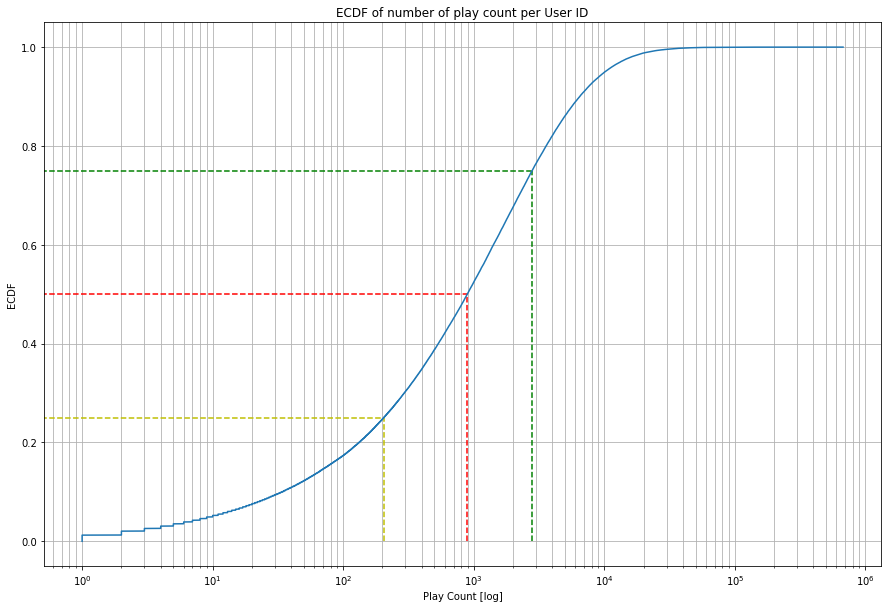



Play count quantile (with 0.1%-wide ranges):
0.1        34.0
0.2       132.0
0.3       293.0
0.4       535.0
0.5       892.0
0.6      1415.0
0.7      2226.0
0.8      3584.0
0.9      6484.0
1.0    674412.0
Name: 1, dtype: float64


Play count quantile (with 0.25%-wide ranges):
0.25       204.0
0.50       892.0
0.75      2800.0
1.00    674412.0
Name: 1, dtype: float64




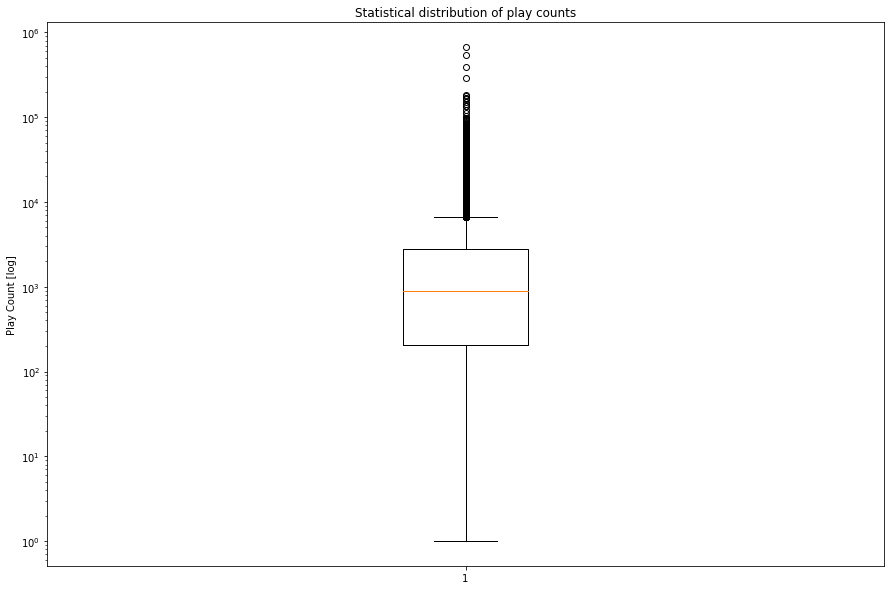

In [105]:
# CREATION OF THE PANDAS DATAFRAME
pdf = pd.DataFrame(data=userActivity)

# ECDF CREATION
Y = np.sort(pdf[1])       # sorted play counts
yvals = np.arange(len(Y))/float(len(Y))  # evenly spaced interval

# ECDF PLOT
plt.figure(figsize=(15,10))
plt.semilogx(Y, yvals)
plt.xlabel('Play Count [log]')
plt.ylabel('ECDF')
plt.grid(True, which="both", ls="-")
plt.title('ECDF of number of play count per User ID')
plt.vlines(np.percentile(Y, 25), 0, 0.25, linestyle="dashed", color = 'y')
plt.hlines(0.25, 0, np.percentile(Y, 25), linestyle="dashed", color ='y')
plt.vlines(np.percentile(Y, 50), 0, 0.5, linestyle="dashed", color = 'r')
plt.hlines(0.5, 0, np.percentile(Y, 50), linestyle="dashed", color ='r')
plt.vlines(np.percentile(Y, 75), 0, 0.75, linestyle="dashed", color = 'g')
plt.hlines(0.75, 0, np.percentile(Y, 75), linestyle="dashed", color ='g')
yellow_patch = mpatches.Patch(color='yellow', label='25th percentile')
red_patch = mpatches.Patch(color='red', label='50th percentile')
green_patch = mpatches.Patch(color='green', label='75th percentile')
plt.legend(handles=[yellow_patch, red_patch, green_patch])
plt.show()

# LESS PRECISE COMPUTATIONS
print()
print()
print('Play count quantile (with 0.1%-wide ranges):')
print(pdf.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])[1])
print()
print()
print('Play count quantile (with 0.25%-wide ranges):')
print(pdf.quantile([0.25,0.50,0.75,1.00])[1])
print()
print()

# Y-LOGARITHMIC BOXPLOT
plt.figure(figsize=(15,10))
plt.boxplot(Y)
plt.yscale('log')
plt.ylabel('Play Count [log]')
plt.title('Statistical distribution of play counts')
plt.show()

<div class="alert alert-success">
First of all, we can look at the most important percentiles:<br>
- the **25th** percentile has a play count of 204<br>
- the **median** of the play counts is of 892<br>
- the **75th** percentile instead, reaches 2800 plays<br>
- the **tails** like 80th and 90th percentiles are, respectively, of 3584 and 6484<br>
The data obtained is coherent with the previous graph. The function is really steep, for this reason we used a logarithmic x-scale in order to better highlight the shape.<br>
<br>
Given the fact that the maximum (percentile 100%) is 674412, we can notice that there is a huge gap between the 90% and the 100% percentiles. This means that the statistical 'tail' of the users has a **huge count** compared to the others.<br>
<br>
The users that have a very low playcount can represent a difficult case for our recommendation algorithm: as in other cases of recommending products, songs or items in general, a prediction is very hard for users which don't partecipate a lot in the system that is considered. We will see in the next phases if this will be an issue.
</div>

#### Question 2.3

<div class="alert alert-info">
How many play counts for each artist? Plot CDF or ECDF of the result.  

Similarly to the previous question, you need to comment and interpret your result: what is the figure telling you?
</div>

In [106]:
artistPopularity = userArtistDF.groupBy('artistID').sum('playCount')

displayDF(artistPopularity.sample(True, 0.000004).toPandas(), ["ArtistID", "sum(PlayCount)"])
artistPopularity = artistPopularity.collect()

ArtistID,sum(PlayCount)
10511823,1
10303422,303
10346296,1
1319123,7
10650325,9
10501210,1


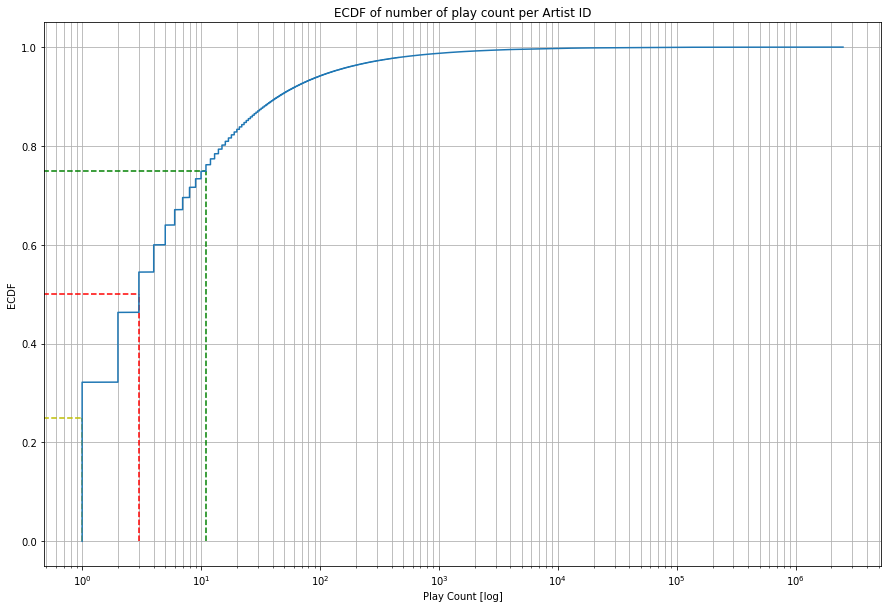



Play count quantile (with 0.1%-wide ranges):
0.1          1.0
0.2          1.0
0.3          1.0
0.4          2.0
0.5          3.0
0.6          5.0
0.7          8.0
0.8         15.0
0.9         45.0
1.0    2502130.0
Name: 1, dtype: float64


Play count quantile (with 0.25%-wide ranges):
0.25          1.0
0.50          3.0
0.75         11.0
1.00    2502130.0
Name: 1, dtype: float64




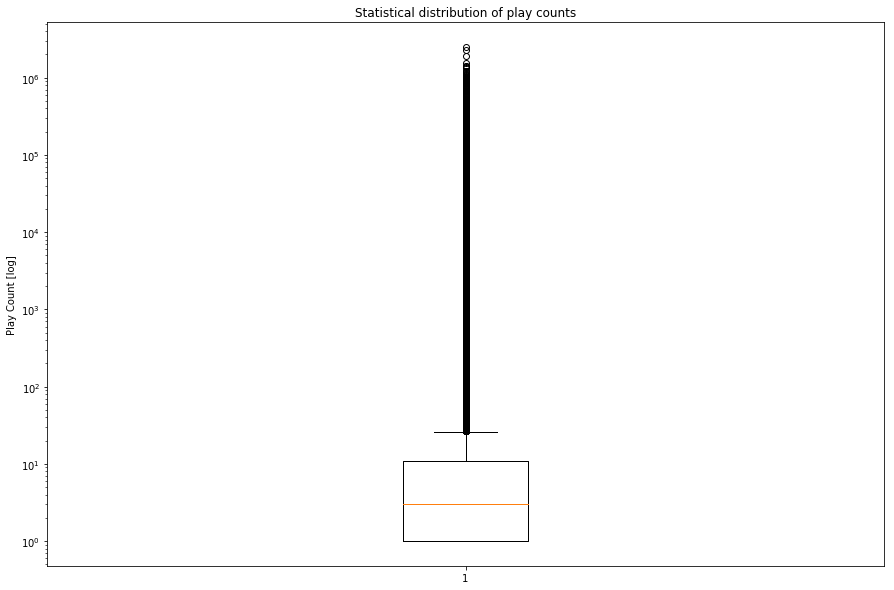

In [107]:
# CREATION OF THE PANDAS DATAFRAME
pdf = pd.DataFrame(data=artistPopularity)

# ECDF CREATION
Y = np.sort(pdf[1])                      # sorted play counts
yvals = np.arange(len(Y))/float(len(Y))  # evenly spaced interval

# ECDF PLOT
plt.figure(figsize=(15,10))
plt.semilogx(Y, yvals)
plt.xlabel('Play Count [log]')
plt.ylabel('ECDF')
plt.grid(True, which="both", ls="-")
plt.title('ECDF of number of play count per Artist ID')
plt.vlines(np.percentile(Y, 25), 0, 0.25, linestyle="dashed", color = 'y')
plt.hlines(0.25, 0, np.percentile(Y, 25), linestyle="dashed", color ='y')
plt.vlines(np.percentile(Y, 50), 0, 0.5, linestyle="dashed", color = 'r')
plt.hlines(0.5, 0, np.percentile(Y, 50), linestyle="dashed", color ='r')
plt.vlines(np.percentile(Y, 75), 0, 0.75, linestyle="dashed", color = 'g')
plt.hlines(0.75, 0, np.percentile(Y, 75), linestyle="dashed", color ='g')
yellow_patch = mpatches.Patch(color='yellow', label='25th percentile')
red_patch = mpatches.Patch(color='red', label='50th percentile')
green_patch = mpatches.Patch(color='green', label='75th percentile')
plt.legend(handles=[yellow_patch, red_patch, green_patch])
plt.show()

# LESS PRECISE COMPUTATIONS
print()
print()
print('Play count quantile (with 0.1%-wide ranges):')
print(pdf.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])[1])
print()
print()
print('Play count quantile (with 0.25%-wide ranges):')
print(pdf.quantile([0.25,0.50,0.75,1.00])[1])
print()
print()

# Y-LOGARITHMIC BOXPLOT
plt.figure(figsize=(15,10))
plt.boxplot(Y)
plt.yscale('log')
plt.ylabel('Play Count [log]')
plt.title('Statistical distribution of play counts')
plt.show()

<div class="alert alert-success">
First of all, we can look at the most important percentiles:<br>
- the **25th** percentile has a play count of 1<br>
- the **median** of the play counts is of 3<br>
- the **75th** percentile instead, reaches 11 plays<br>
- the **tails** like 80th and 90th percentiles are, respectively, of 15 and 45<br>
<br>
The 100th percentile shows, as we've seen before, a huge number of plays (of the order of 10^6).<br>
This is interesting: it means that the majority of the artists are not very played, while there are some extremely famous artists that are hugely played. Until the 90% percentile, the number of plays is 45, that is a really **small quantity with respect to the huge number of plays received by the 100% of the artists**.<br>
It's possible that this result is caused by uncleaned data, like mispelled artists, that could bring a lot of artistIDs that correspond to a single real artist.<br>
Obviously this can be an issue for the recommendations: the very little portion of very famous artists will be very recommended and the other artists would be excluded.
</div>

#### Question 2.4
<div class="alert alert-info">
Plot a bar chart to show top 5 artists In terms of absolute play counts.  

Comment the figure you just obtained: 
<ul>
<li>are these reasonable results?</li>
<li>is looking at top-5 artists enough to learn more about your data?</li>
<li>do you see anything strange in the data?</li>
</ul>
</div>

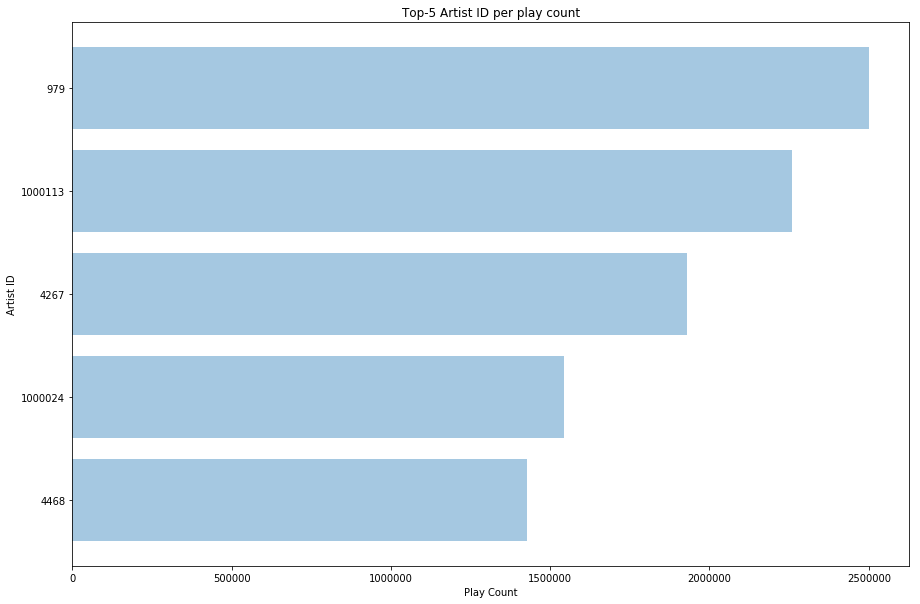

In [108]:
# TOP 5 ARTISTS
sortedArtist = sorted(artistPopularity, key = lambda x: -x[1])[0:5]

artistID = [w[0] for w in sortedArtist]
frequency = [w[1] for w in sortedArtist]
y_pos = range(len(sortedArtist))

plt.figure(figsize=(15,10))
plt.barh(y_pos, frequency[::-1], align='center', alpha=0.4)
plt.yticks(y_pos, artistID[::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist ID')
plt.title('Top-5 Artist ID per play count')
plt.show()

<div class="alert alert-success">
Obtained data seems to be reasonable but looking at this graph only is **not enough** to conclude something. We don't learn anything about the distribution, we don't know how the gaps between ranked artists change, we don't know if the rank is correct: all these aspects could be influenced by dirty data. We should clean as much as possible our data in order to have correct values of absolute play counts. After that we can study better our data and we can conclude if the cleaning process considerably change the characteristics of our analysis.

We are going to do this further. At the moment we can plot the top-50 of the same graph in order to have a more general picture of our data.
</div>

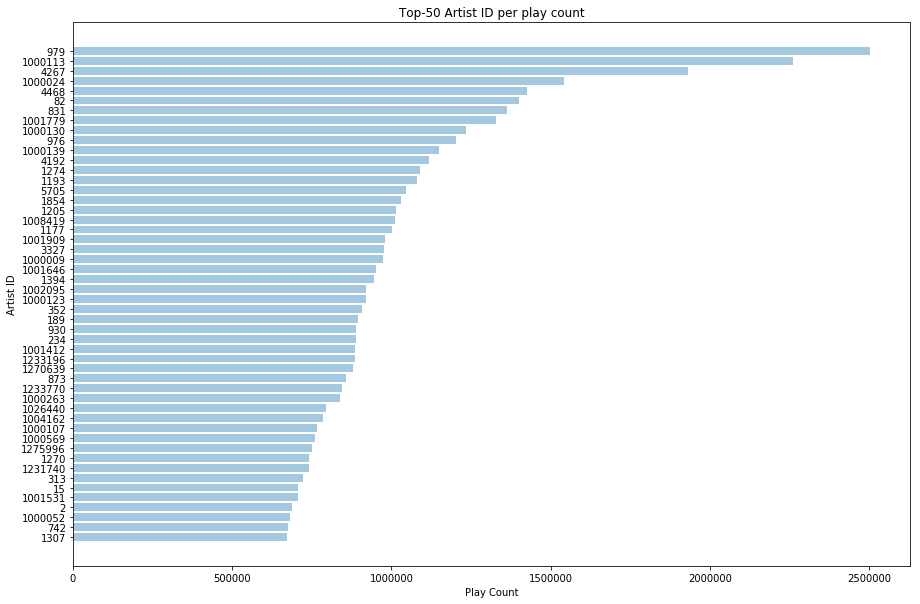

In [109]:
# TOP 50 ARTISTS
sortedArtist = sorted(artistPopularity, key = lambda x: -x[1])[0:50]

artistID = [w[0] for w in sortedArtist]
frequency = [w[1] for w in sortedArtist]
y_pos = range(len(sortedArtist))

plt.figure(figsize=(15,10))
plt.barh(y_pos, frequency[::-1], align='center', alpha=0.4)
plt.yticks(y_pos, artistID[::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist ID')
plt.title('Top-50 Artist ID per play count')
plt.show()

<div class="alert alert-success">
From this more general point of view, we can notice how the first artists have a very big playCount compared to the others. The difference of playCount is smaller and smaller as we go through the ranking, while the first few artists are a lot more listened.
</div>

All seems clear right now, but ... wait a second! What about the problems indicated above about artist "disambiguation"? Are these artist ID we are using referring to unique artists? How can we make sure that such "opaque" identifiers point to different bands? Let's try to use some additional dataset to answer this question:  `artist_data.txt` dataset. This time, the schema of the dataset consists in:

```
artist ID: long int
name: string
```

We will try to find whether a single artist has two different IDs.

### Question 3

#### Question 3.1

<div class="alert alert-info">
Load the data from `/datasets/lastfm/artist_data.txt` and use the SparkSQL API to show 5 samples.  

<ul></ul>
<div class="label label-success">HINT:</div> If you encounter some error when parsing lines in data because of invalid entries, parameter `mode='DROPMALFORMED'` will help you to eliminate these entries. The suggested syntax is: `<df>.options(header='false', delimiter='\t', mode='DROPMALFORMED')`.

</div>

In [110]:
customSchemaArtist = StructType([ \
    StructField("artistID", LongType(), True), \
    StructField("name", StringType(), True)])

artistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t', mode='DROPMALFORMED') \
    .load(base + 'artist_data.txt', schema=customSchemaArtist)

artistDF.cache()
displayDF(artistDF.sample(True, 0.000003).toPandas(), ["ArtistID", "Name"])

ArtistID,Name
2021439,John Atkinson
6713716,Ludwig Van Beethoven / Naoki Maeda / Terry & A...
6878016,the kids need guns
6882713,The Ride Theory
1038494,Mocket


#### Question 3.2
<div class="alert alert-info">
Find 20 artists whose name contains `Aerosmith`. Take a look at artists that have ID equal to `1000010` and `2082323`. In your opinion, are they pointing to the same artist?  

<ul></ul>
<div class="label label-success">HINT:</div> Function `locate(sub_string, string)` can be useful in this case.
</div>

In [111]:
# get artists whose name contains "Aerosmith"
displayDF(artistDF[locate("Aerosmith", "name") > 0].sample(True, 0.05).toPandas(), ["ArtistID", "Name"])

# show two examples
displayDF(artistDF[artistDF.artistID==1000010].toPandas(), ["ArtistID", "Name"])
displayDF(artistDF[artistDF.artistID==2082323].toPandas(), ["ArtistID", "Name"])

ArtistID,Name
10475683,Aerosmith: Just Push Play
10588537,"Aerosmith, Kid Rock, & Run DMC"
1179753,26. Aerosmith
1179753,26. Aerosmith
10670881,Guns N' Roses with Aerosmith
10065763,"The Cranberries, Counting Crows, Soundgarden, ..."
10516997,354. Aerosmith
1005342,Aerosmith (Virgin Radio
10697742,Green Day/ Oasis/Travis/Aerosmith
1121355,Aerosmith {Get A Grip} 05


ArtistID,Name
1000010,Aerosmith


ArtistID,Name
2082323,01 Aerosmith


<div class="alert alert-success">
Of course the two artistIDs point to the same artist, but they differ because in the second case we have a mispelled name. This is a **big issue** for our analysis. Other similar issues could be the featurings (e.g. <i>"Aerosmith + Run DMC"</i> or <i>"Aerosmith/ G n R"</i>).
</div>

To answer this question correctly, we need to use an additional dataset `artist_alias.txt` which contains the ids of mispelled artists and standard artists. The schema of the dataset consists in:

```
mispelledID ID: long int
standard ID: long int
```

#### Question 3.3
<div class="alert alert-info">
Using SparkSQL API, load the dataset from `/datasets/lastfm/artist_alias.txt` then show 5 samples.
</div>

In [112]:
customSchemaArtistAlias = StructType([ \
    StructField("mispelledID", LongType(), True), \
    StructField("standardID", LongType(), True)])

artistAliasDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t', mode='DROPMALFORMED') \
    .load(base + 'artist_alias.txt', schema=customSchemaArtistAlias)

artistAliasDF.cache()
displayDF(artistAliasDF.sample(True, 0.00003).toPandas(), ["MispelledID", "StandardID"])

MispelledID,StandardID
6862684,1010349
6893402,1005290
1198317,1274
1278001,3402
6945167,4449
1081859,5705
1157830,10365001


#### Question 3.4
<div class="alert alert-info">
Verify the answer of question 3.2 ("Are artists that have ID equal to `1000010` and `2082323` the same ?") by finding the standard ids corresponding to the mispelled ids `1000010` and `2082323` respectively.
</div>

In [113]:
displayDF(artistAliasDF[artistAliasDF['mispelledID']==1000010].toPandas(), ["MispelledID", "StandardID"])
displayDF(artistAliasDF[artistAliasDF['mispelledID']==2082323].toPandas(), ["MispelledID", "StandardID"])

MispelledID,StandardID


MispelledID,StandardID
2082323,1000010


<div class="alert alert-success">
We can notice that 2082323 is a mispelled artist name, and corresponds to the original artist with ID 11000010.<br>
The ID 11000010 is itself an original one, so it has not been considered as a mispelled artist.
</div>

<div class="alert alert-success">
<p style='font-size:16px'>**Redundant information removal**</p><br>
We noticed that in the *Artist-Alias DataFrame* there were multiple lines <strong>containing useless informations</strong>;
in different words, the mispelledID was <strong>identical</strong> to the standardID.<br>
Let's show an example and remove them:
</div>

In [114]:
# FURTHER COMPARISON TO SHOW THAT FOR SOME ENTRIES mispelledID = standardID
displayDF(artistAliasDF[artistAliasDF['mispelledID']==15].toPandas(), ["MispelledID", "StandardID"])

MispelledID,StandardID
15,15


In [115]:
# ARTIST ALIAS DATA CLEANING (USELESS ROW REMOVAL)
artistAliasDFnew = artistAliasDF.where("mispelledID != standardID")

# MESSAGE PRINT
print("The number of rows, that before was", artistAliasDF.count(), "now is", artistAliasDFnew.count())

# OVERWRITE
artistAliasDF = artistAliasDFnew

The number of rows, that before was 193027 now is 190881


### Question 4

The mispelled or nonstandard information about artist make our results in the previous queries a bit "sloppy". To overcome this problem, we can replace all mispelled artist ids by the corresponding standard ids and re-compute the basic descriptive statistics on the "amended" data.
First, we construct a "dictionary" that maps non-standard ids to a standard ones. Then this "dictionary" will be used to replace the mispelled artists.

#### Question 4.1
<div class="alert alert-info">
From data in the dataframe loaded from `/datasets/lastfm/artist_alias.txt`, construct a dictionary that maps each non-standard id to its standard id.  

<div class="label label-success">HINT:</div> Instead of using function `collect`, we can use `collectAsMap` to convert the collected data to a dictionary inline.
</div>

In [116]:
artistAlias = artistAliasDF.rdd.map(lambda row: (row[0], row[1])).collectAsMap()

#### Question 4.2
<div class="alert alert-info">
Using the constructed dictionary in question 4.1, replace the non-standard artist ids in the dataframe that was loaded from `/datasets/lastfm/user_artist_data.txt` by the corresponding standard ids then show 5 samples.
</div>


**NOTE 1**: If an id doesn't exist in the dictionary as a mispelled id, it is really a standard id.


Using funtion `map` on Spark Dataframe will give us an RDD. We can convert this RDD back to Dataframe by using `sqlContext.createDataFrame(rdd_name, sql_schema)`


**NOTE 2**: be careful! you need to be able to verify that you indeed solved the problem of having bad artist IDs. In principle, for the new data to be correct, we should to have duplicate pairs (user, artist), potentially with different play counts, right? In answering the question, please **show** that you indeed fixed the problem. 

In [117]:
# FUNCTION TO REPLACE THE MISPELLED ID WITH THE ORIGINAL ONE
def replaceMispelledIDs(fields):
    finalID = artistAlias.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

# FUNCTION TO REPLACE THE MISPELLED ID WITH THE ORIGINAL ONE
# (Slightly different from the previous one, because it
#  return a (key,value) pair, ready to be reducedByKey)
def replaceMispelledIDsToKV(fields):
    finalID = bArtistAlias.value.get(fields[1], fields[1])
    return ((fields[0], finalID), fields[2])

In [119]:
from time import time

# START TIME
t0 = time()

# CLEANING
# (the double cleaning (map) phase is explained in the comment below)
newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd \
        .map(replaceMispelledIDs) \
        .map(replaceMispelledIDsToKV) \
        .reduceByKey(lambda c1, c2: c1 + c2) \
        .map(lambda pair: (pair[0][0], pair[0][1], pair[1])), 
    userArtistDataSchema
)

'''
# SECOND CLEANING PHASE (EXPLAINED IN THE COMMENT BELOW)
newUserArtistDF = sqlContext.createDataFrame(
    newUserArtistDF.rdd.map(replaceMispelledIDs).filter(lambda triplet: triplet[1] != 1034635), 
    userArtistDataSchema
)
'''

# END TIME
t1 = time()

# PRINT RESULTS
print('The script takes %f seconds' %(t1-t0))
# displayDF(newUserArtistDF.sample(True, 0.0000008).toPandas(), ["UserID", "ArtistID", "PlayCount"])
# newUserArtistDF.show()

The script takes 2.483966 seconds


<div class="alert alert-success">
<p style='font-size:16px'>**The second cleaning phase**</p><br>
As it can be noticed by the code, we cleaned our data **twice**: we replaced the mispelledID with the standardID not only one time, but two times.<br>
This has been done for a concrete reason: some *standardID*s were not standard, but other mispelled id. In other words:<br>
there were some **little "chains"** in the dataset! The obtained *standardID* had to be used another time (as a *mispelledID*) to get the real *standardID*.<br>
</div>

<div class="alert alert-success">
<p style='font-size:16px'>**The 'Unknown' artist problem**</p>
<br>
Doing some investigations and having some strange results in the other parts of the notebook, we found out that there is a user in the dataset, with ID 1034635, named '[Unknown]'. This can be a big problem! So, we investigated more, and we found out that **a lot** of *mispelledID*s, with strange (and wrong, mispelled) names were mapped to this *standardID*. That's an issue:<br>
this means that a lot of plays done on each single mispelled artist then sum up to the counter of '[Unknown]'! Making it a very listened artist, and so **potentially recommended** by the model!<br>
We have to remove all the entries mapped to this ID. But, before, we can quantify the problem. Let's do it:
</div>

In [120]:
newUserArtistDF \
    .where("artistID == 1034635") \
    .agg(sum('playCount')) \
    .show()

+--------------+
|sum(playCount)|
+--------------+
|        429447|
+--------------+



<div class="alert alert-success">
**Wow, that's huge!**<br>
A big number of plays are summed up in the counter of the artist '[Unknown]'! If it would have been a single artist, that for some reason hadn't the name set, it would not be a problem. But in this case, a lot of artists are mapped to the Unknown ID, making it famouse without being anyone!<br>
<br>
Now it's clear, we have to **remove** all the entries related to him:
</div>

In [121]:
# FILTER
newUserArtistDF = newUserArtistDF.where("artistID != 1034635")

# CHECK AGAIN
newUserArtistDF \
    .where("artistID == 1034635") \
    .agg(sum('playCount')) \
    .show()

+--------------+
|sum(playCount)|
+--------------+
|          null|
+--------------+



<div class="alert alert-success">
Ok, the problem is gone.<br>
</div>

<div class="alert alert-success">
Now, we can go on with the **checks** that our mispelledID correction worked well:
</div>

In [122]:
# RECHECK WITH THE MISPELLED ARTIST IDs,
# TO CHECK THAT THE JOIN WITH THEM GIVES 0 VALUES
artistAliasJoinUserArtist = newUserArtistDF \
    .join(artistAliasDF, newUserArtistDF.artistID == artistAliasDF.mispelledID) 

displayDF(artistAliasJoinUserArtist.toPandas(), ["UserID", "ArtistID", "PlayCount", "MispelledID", "StandardID"])

UserID,ArtistID,PlayCount,MispelledID,StandardID


<div class="alert alert-success">
**The check: join between the *artistID*s and all the *mispelledID*s**<br>
From this second result we can see that a join between the *'User-Artist' DataFrame* and the *'Artist-Alias' DataFrame*, doesn't show any result.<br>
This is a clear and expected result: we cleaned well our dataset from all the *mispelledID*s.
</div>

#### Question 4.3
<div class="alert alert-info">
Spark actions are executed through a set of stages, separated by distributed "shuffle" operations. Spark can be instructed to **automatically and efficiently** broadcast common data needed by tasks within **each stage**. The data broadcasted this way is cached in **serialized form** and deserialized before running each task.   
<ul> </ul>
We can thus improve our answer to question 4.2: we can reduce the communication cost by shipping the "dictionary" in a more efficient way by using `broadcast variable`. Broadcast variables allow the programmer to keep a read-only variable cached on **each machine** rather than shipping a copy of it with tasks. They are cached in deserialized form. They can be used, for example, to give every node a copy of a large input dataset in an efficient manner.   
<ul></ul>
The broadcast of variable `v` can be created by `bV = sc.broadcast(v)`. Then value of this broadcast variable can be access via `bV.value`  

<ul></ul>
To question is then: using a broadcast variable, modify the script in question 4.2 to get better performance in terms of running time.
</div>


In [123]:
from time import time

# BROADCAST THE MISPELLING DICTIONARY
bArtistAlias = sc.broadcast(artistAlias)

# START TIME
t0 = time()

# CLEANING
# - first of all we do the classic cleaning phase, using map with 'replaceMispelledIDs'
# - then use use anothe map FOR THE SECOND CLEANING PHASE, using the modified version...
#   ...of the replace function, that returns already a (key,value) pair
# - with the filter function we remove the Unknown artist
# - the reduceByKey is done to compact the duplicates (user,artist) rows that are generated
newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd \
        .map(replaceMispelledIDs)
        .map(replaceMispelledIDsToKV) \
        .reduceByKey(lambda c1, c2: c1 + c2) \
        .map(lambda pair: (pair[0][0], pair[0][1], pair[1])), 
    userArtistDataSchema
)


# END TIME
t1 = time()

# PRINT RESULTS
print('The script takes %f seconds' %(t1-t0))
newUserArtistDF.cache()
# displayDF(newUserArtistDF.sample(True, 0.0000004).toPandas(), ["UserID", "ArtistID", "PlayCount"])
# newUserArtistDF.show()

The script takes 2.444450 seconds


DataFrame[userID: bigint, artistID: bigint, playCount: int]

Although having some advantages, explicitly creating broadcast variables is only useful when tasks across multiple stages need the same data or when caching the data in deserialized form is important.

<div class="alert alert-success">
Using broadcast variables our cleaning algorithm is so much **faster** than the previous implementation. The huge difference between the execution times is a clear sign that the communications over the network have a **non-indifferent cost**. When appropiate, the use of broadcast variables is very time-saving.
</div>

In [124]:
# CLEAN AGAIN (EXPLAINED BELOW)
newUserArtistDF = newUserArtistDF.where("artistID != 1034635")

<div class="alert alert-success">
We clean again the DataFrame because, obviously, repeating the experiment with the broadcast variables (so starting again from the original DataFrame) made it reappear.<br>
We choose to don't modify the original RDD to avoid to influence the "speed test" between the algorithm with the broadcast variables, and the one without.
</div>

### Question 5

Well, our data frame contains clean and "standard" data. We can use it to redo previous statistic queries.

#### Question 5.1
<div class="alert alert-info">
How many unique artists? Compare with the result when using old data.
</div>

In [125]:
# COUNT THE NEW NUMBER OF ARTISTS
newUniqueArtists = newUserArtistDF.select('artistID').distinct().count()

# PRINT THE DIFFERENCE
print('The number of different artistIDs, that previously was',
    uniqueArtists, ', now is', newUniqueArtists, '.')
print('The difference is', uniqueArtists-newUniqueArtists,
    'representing the', "{0:.2f}".format((uniqueArtists-newUniqueArtists)*100/uniqueArtists), '% of the artists.')

# OVERWRITE
uniqueArtists = newUniqueArtists

The number of different artistIDs, that previously was 1631028 , now is 1568116 .
The difference is 62912 representing the 3.86 % of the artists.


<div class="alert alert-success">
The difference of unique *artistID*s is relevant: our mispelling correction **worked fine**, correcting the mispelled artistIDs.
</div>

#### Question 5.2

<div class="alert alert-info">
Who are the top-10 artists?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "audience size", that is, how many users listened to one of their track at least once</li>
</ul>  

Plot the results, and explain the figures you obtain.
<div>

<div class="alert alert-success">
For the following results, we didn't use the *Arist-Data DataFrame*, so we showed only the ID's in the y-axis.<br>
At the moment indeed, we're interested only in the statistics: play count, audience and curiosity.<br>
In other parts of the notebook, we'll check who these artists are, to make the analysis **more interesting**.
</div>

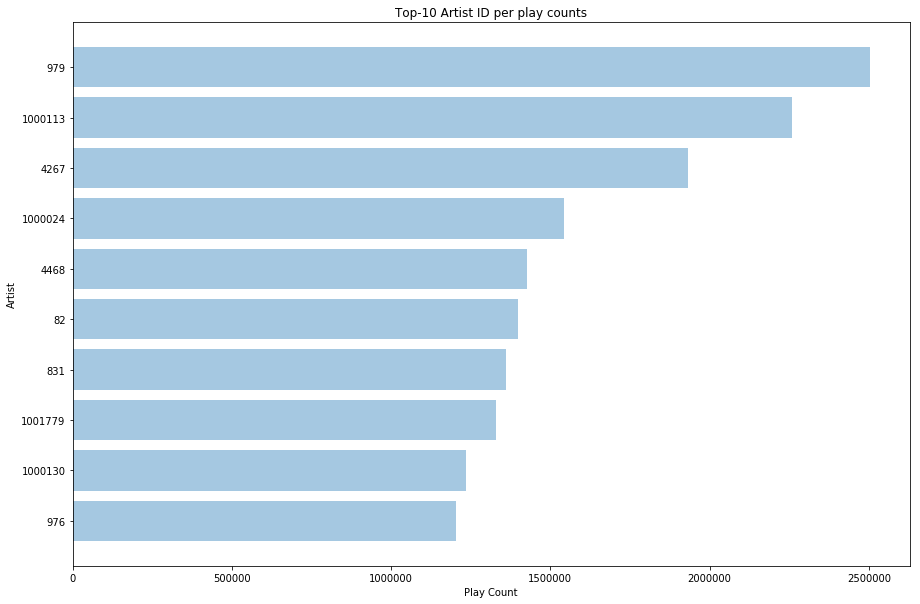

In [127]:
# TOP-10 ARTISTS IN TERM OF PLAY COUNTS
top10ArtistsPC = newUserArtistDF \
    .groupBy('artistID') \
    .sum('playCount') \
    .orderBy('sum(playCount)', ascending=0) \
    .take(10)

# PLOT THE RESULTS
y_pos = range(len(top10ArtistsPC))
pdf = pd.DataFrame(data=top10ArtistsPC)
plt.figure(figsize=(15,10))
plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per play counts')
plt.show()

<div class="alert alert-success">
The number of play counts in the top-10 of the artists is obviously changed: now the play counts **are bigger**, because the plays done on the "mispelled artists" are now counted in the original one.<br>
However the results are not so different, because they have a very limited impact in the top-10: they, for example, **don't change the chart order**.
</div>

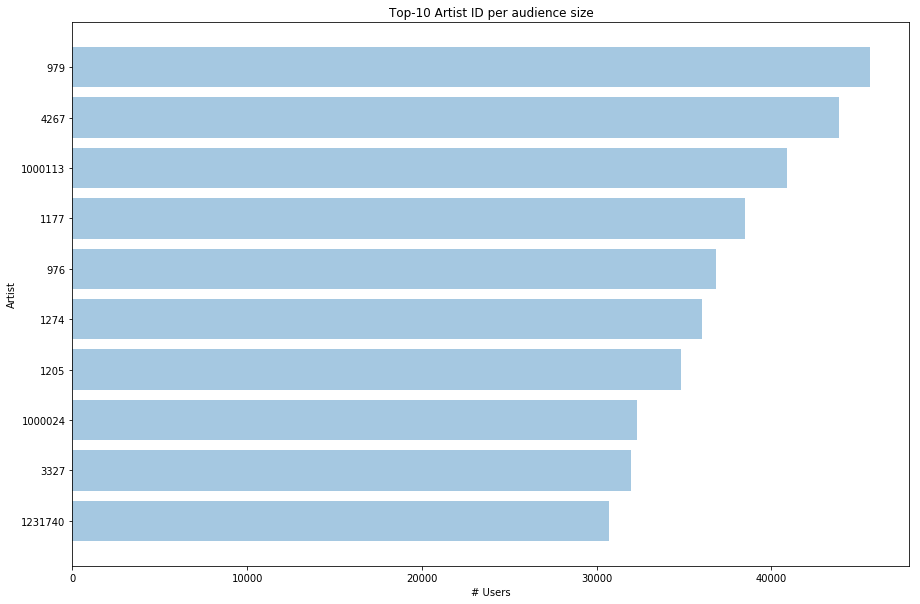

In [128]:
# TOP-10 ARTISTS IN TERM OF AUDIENCE
top10ArtistsAU = newUserArtistDF \
    .groupBy('artistID') \
    .agg(countDistinct('userID').alias('count(userID)')) \
    .orderBy('count(userID)', ascending=0) \
    .take(10)

# PLOT THE RESULTS
y_pos = range(len(top10ArtistsAU))
pdf = pd.DataFrame(data=top10ArtistsAU)
plt.figure(figsize=(15,10))
plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('# Users')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per audience size')
plt.show()

<div class="alert alert-success">
**Audience chart vs Play Count chart: how many on both?**<br>
The "top-10 per audience size" graph is not really interesting per se but it confirms that there is a strong correlation between number of plays and popularity (that we call "audience" in this case). An artist with a huge number of plays is clearly really famous and for this reason we can find its ID in this graph too. Maybe it is better taking a look at a new graph which highlight this fact.
</div>

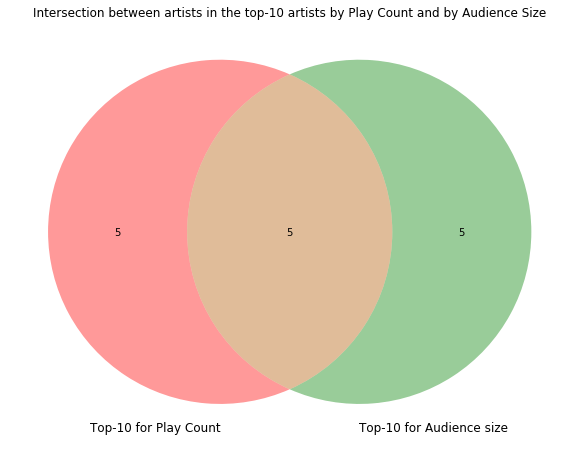

In [133]:
# VENN DIAGRAM
plt.figure(figsize=(10,10))
venn2([set(pd.DataFrame(data=top10ArtistsPC)[0]), set(pd.DataFrame(data=top10ArtistsAU)[0])], set_labels=("Top-10 for Play Count","Top-10 for Audience size"))
plt.title('Intersection between artists in the top-10 artists by Play Count and by Audience Size')
plt.show()


<div class="alert alert-success">
The result is reasonable from the logical point of view: 5 of the most listened artists have also the most various audience. This shows that the audience variety is not totally in line with the absolute play count but, as expected, has some sort of correlation.
</div>

#### Question 5.3

<div class="alert alert-info">
Who are the top-10 users?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "curiosity", that is, how many different artists they listened to</li>

</ul>  

Plot the results
</div>

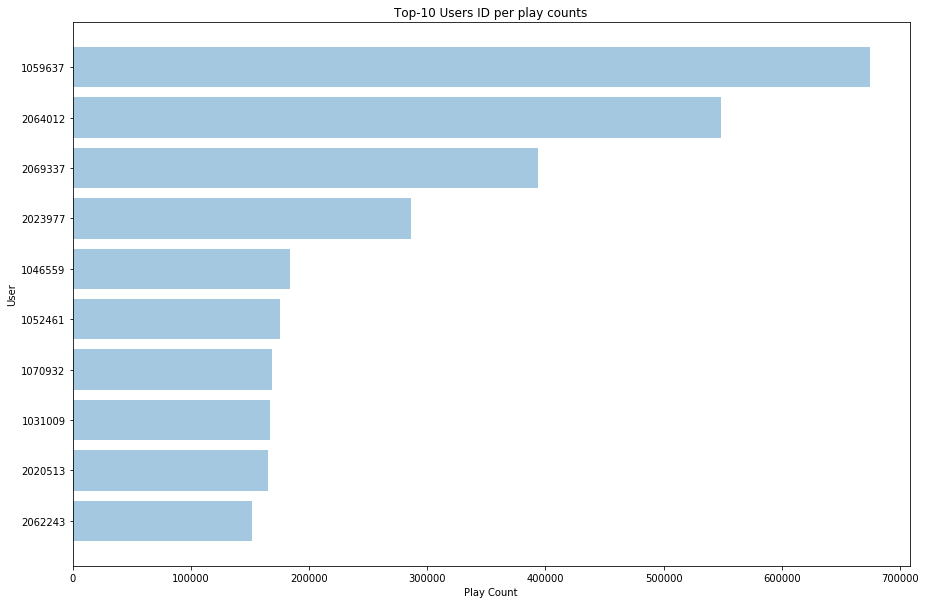

In [134]:
# TOP-10 USERS IN TERM OF PLAY COUNTS
top10UsersPC = newUserArtistDF \
    .groupBy('userID') \
    .sum('playCount') \
    .orderBy('sum(playCount)', ascending=0) \
    .take(10)

# PLOT THE RESULTS
y_pos = range(len(top10UsersPC))
pdf = pd.DataFrame(data=top10UsersPC)
plt.figure(figsize=(15,10))
plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Play Count')
plt.ylabel('User')
plt.title('Top-10 Users ID per play counts')
plt.show()

<div class="alert alert-success">
The chart above graphically shows the information that we simple play count of each user: in the chart we can see that there is a small subset (of 4 users) that has a very hight play count compared to the other users. From the 5th user and following, indeed, the users have a similar play count.
</div>

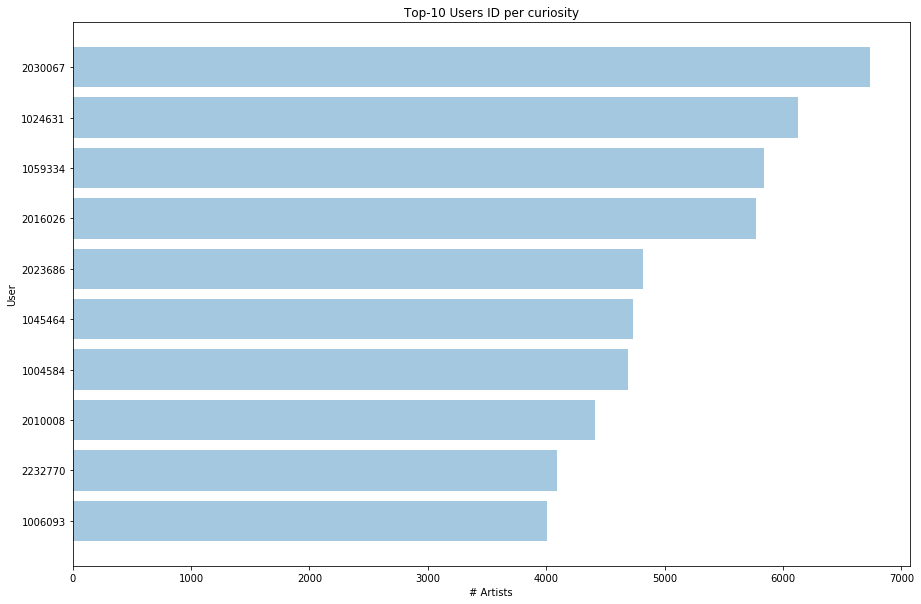

In [135]:
# TOP-10 USERS IN TERM OF CURIOSITY
top10UsersCU = newUserArtistDF \
    .groupBy('userID') \
    .agg(countDistinct('artistID').alias('count(artistID)')) \
    .orderBy('count(artistID)', ascending=0) \
    .take(10)

# PLOT THE RESULTS
y_pos = range(len(top10UsersCU))
pdf = pd.DataFrame(data=top10UsersCU)
plt.figure(figsize=(15,10))
plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('# Artists')
plt.ylabel('User')
plt.title('Top-10 Users ID per curiosity')
plt.show()

<div class="alert alert-success">
**Curiosity chart vs Play Count chart: how many on both?**<br>
With the following set of code we'll check how many users are **both** in the top-10 curious users and the top-10 play count users.
</div>

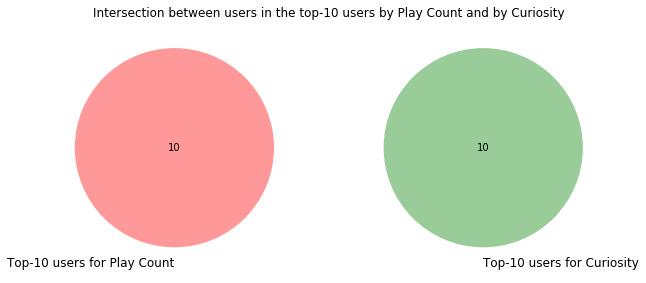

In [136]:
# VENN DIAGRAM
plt.figure(figsize=(10,10))
venn2([set(top10UsersPC), set(top10UsersCU)], set_labels=("Top-10 users for Play Count","Top-10 users for Curiosity"))
plt.title('Intersection between users in the top-10 users by Play Count and by Curiosity')
plt.show()

<div class="alert alert-success">
The result obtained is totally different with respect to the one regarding the artists. The most active users in terms of play counts, are totally different from the top-10 users in terms of curiosity (variety of listened artists).<br>
This is an interesting result: the users that listen a lot in absolute values, are listening mainly to a little set of artists, compared to the users which spans a big set of artists, but maybe listen to less music than the others.<br>
Thinking about that after having got the results lead us to a conclusion: it makes sense. The quantity of listened music and the quantity of different artists listened is, in some way, not so correlated. Of course, if a user has a play count of very few songs, it's impossible that he will have a big curiosity value! But when we deal with users that have a strong play count value, the correlations gets weaker.
</div>

Now we have some valuable information about the data. It's the time to study how to build a statistical models.

# 2. Build a statistical models to make recommendations

## 2.1 Introduction to recommender systems

In a recommendation-system application there are two classes of entities, which we shall refer to as `users` and `items`. Users have preferences for certain items, and these preferences must be inferred from the data. The data itself is represented as a `preference matrix` $A$, giving for each user-item pair, a value that represents what is known about the degree of preference of that user for that item. The table below is an example for a `preference matrix` of 5 users and `k` items. The `preference matrix` is also known as `utility matrix`.

| | IT1 | IT2 | IT3 | ... | ITk |
|---|---|---|---|---|---|
| U1 | 1 |  | 5 | ... | 3 |
| U2 |  | 2 |  | ... | 2 |
| U3 | 5 |  | 3 | ... |  |
| U4 | 3 | 3 |  | ... | 4 |
| U5 |  | 1 |  | ... | ... |

The value of row i, column j expresses how much does user `i` like item `j`. The values are often the rating scores of users for items. An unknown value implies that we have no explicit information about the user's preference for the item. The goal of a recommendation system is to predict "the blanks" in the `preference matrix`. For example, assume that the rating score is from 1 (dislike) to 5 (love), would user `U5` like `IT3` ? We have two approaches:

* Designing our recommendation system to take into account properties of items such as brand, category, price... or even the similarity of their names. We can denote the similarity of items `IT2` and `IT3`, and then conclude that because user `U5` did not like `IT2`, they were unlikely to enjoy SW2 either.

* We might observe that the people who rated both `IT2` and `IT3` tended to give them similar ratings. Thus, we could conclude that user `U5` would also give `IT3` a low rating, similar to `U5`'s rating of `IT2`

It is not necessary to predict every blank entry in a `utility matrix`. Rather, it is only necessary to discover some entries in each row that are likely to be high. In most applications, the recommendation system does not oﬀer users a ranking of all items, but rather suggests a few that the user should value highly. It may not even be necessary to ﬁnd all items with the highest expected ratings, but only to ﬁnd a large subset of those with the highest ratings.


## 2.2 Families of recommender systems

In general, recommender systems can be categorized into two groups:

* **Content-Based** systems focus on properties of items. Similarity of items is determined by measuring the similarity in their properties.

* **Collaborative-Filtering** systems focus on the relationship between users and items. Similarity of items is determined by the similarity of the ratings of those items by the users who have rated both items.

In the usecase of this notebook, artists take the role of `items`, and `users` keep the same role as `users`.
Since we have no information about `artists`, except their names, we cannot build a `content-based` recommender system.

Therefore, in the rest of this notebook, we only focus on `Collaborative-Filtering` algorithms.

## 2.3 Collaborative-Filtering 
In this section, we study a member of a broad class of algorithms called `latent-factor` models. They try to explain observed interactions between large numbers of users and products through a relatively small number of unobserved, underlying reasons. It is analogous to explaining why millions of people buy a particular few of thousands of possible albums by describing users and albums in terms of tastes for perhaps tens of genres, tastes which are **not directly observable or given** as data. 

First, we formulate the learning problem as a matrix completion problem. Then, we will use a type of `matrix factorization` model to "fill in" the blanks.  We are given implicit ratings that users have given certain items (that is, the number of times they played a particular artist) and our goal is to predict their ratings for the rest of the items. Formally, if there are $n$ users and $m$ items, we are given an $n \times m$ matrix $R$ in which the generic entry $(u, i)$ represents the rating for item $i$ by user $u$. **Matrix $R$ has many missing entries indicating unobserved ratings, and our task is to estimate these unobserved ratings**.

A popular approach to the matrix completion problem is **matrix factorization**, where we want to "summarize" users and items with their **latent factors**.

### 2.3.1 Basic idea and an example of Matrix Factorization
For example, given a preference matrix 5x5 as below, we want to approximate this matrix into the product of two smaller matrixes $X$ and $Y$ .

$$
M = 
\begin{bmatrix}
 5 & 2 & 4 & 4 & 3 \\
 3 & 1 & 2 & 4 & 1 \\
 2 &  & 3 & 1 & 4 \\
 2 & 5 & 4 & 3 & 5 \\
 4 & 4 & 5 & 4 &  \\
\end{bmatrix}
\approx M^\prime =
\begin{bmatrix}
 x_{11} & x_{12} \\
 x_{21} & x_{22} \\
 x_{31} & x_{32} \\
 x_{41} & x_{42} \\
 x_{51} & x_{52} \\
\end{bmatrix}
\times
\begin{bmatrix}
 y_{11} & y_{12} & y_{13} & y_{14} & y_{15} \\
 y_{21} & y_{22} & y_{23} & y_{24} & y_{25} \\
\end{bmatrix}
$$

$M^\prime$ is an approximation that is as close to A as possible. To calculate how far from $M$ $M^\prime$ is, we often calculate the sum of squared distances of non-empty elements in $M$ and the corresponding elements in $M^\prime$.
In this way, for $M^\prime$, besides the approximated elements in $M$, we also have the non-observed elements. Therefore, to see how much does user `i` like item `j`, we simply pick up the value of $M^\prime_{i,j}$.

The challenge is how to calculate $X$ and $Y$. The bad news is that this can't be solved directly for both the best $X$ and best $Y$ at the same time. Fortunately, if $Y$ is known, we can calculate the best of $X$, and vice versa. It means from the initial values of $X$ and $Y$ in the beginning, we calculate the best $X$ according to $Y$, and then calculate the best $Y$ according to the new $X$. This process is repeated until the distance from $XY$ to $M$ is small. It's simple, right ?

Let's take an example. To compute the approximation for the above 5x5 matrix $M$, first, we initialize the value of $X$ and $Y$ as below.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

With the initial iteration, we calculate the Root-Mean-Square Error from $XY$ to $M$.

Consider the ﬁrst rows of $M$ and $XY$ . We subtract the first row of $XY$ from the entries in the ﬁrst row of $M$, to get $3,0,2,2,1$. We square and sum these to get $18$. 

In the second row, we do the same to get $1,−1,0,2,−1$, square and sum to get $7$. 

In the third row, the second column is blank, so that entry is ignored when computing the RMSE. The diﬀerences are $0,1,−1,2$ and the sum of squares is $6$. 

For the fourth row, the diﬀerences are $0,3,2,1,3$ and the sum of squares is $23$. 

The ﬁfth row has a blank entry in the last column, so the diﬀerences are $2,2,3,2$ and the sum of squares is $21$. 

When we sum the sums from each of the ﬁve rows, we get $18+7+6+23+21 = 75$. So, $RMSE=\sqrt{75/23}=1.806$ where $23$ is the number of non-empty values in $M$.

Next, with the given value of $Y$, we calculate $X$ by finding the best value for $X_{11}$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 x & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 x+1 & x+1 & x+1 & x+1 & x+1 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

Now, to minimize the $RMSE$  we minimize the difference of the first rows $(5−(x+1))^2 + (2−(x+1))^2 + (4−(x+1))^2 + (4−(x+1))^2 + (3−(x+1))^2$. By  taking the derivative and set that equal to 0, we pick $x=2.6$

Given the new value of $X$, we can calculate the best value for $Y$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 2.6 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 y & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 3.6 & 3.6 & 3.6 & 3.6 & 3.6 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

By doing the same process as before, we can pick value for $y=1.617$. After that, we can check if the $RMSE$ is not converged, we continue to update $X$ by $Y$ and vice versa. In this example, for simple, we only update one element of each matrix in each iteration. In practice, we can update a full row or full matrix at once.


### 2.3.2 Matrix Factorization: Objective and ALS Algorithm on a Single Machine

More formally, in general, we select $k$ latent features, and describe each user $u$ with a $k-$dimensional vector $x_u$, and each item $i$ with a $k-$dimensional vector $y_i$.

Then, to predict user $u$'s rating for item $i$, we do as follows: $ r_{ui} \approx x_{u}^{T}y_i$.

This can be put, more elegantly, in a matrix form. Let $x_1, \cdots x_n \in \mathbb{R}^k$ be the factors for the users, and $y_1, \cdots y_m \in \mathbb{R}^k$ the factors for the items. The $k \times n$ user matrix $X$ and the $k \times m$ item matrix $Y$ are then defined by:

$$
X = 
\begin{bmatrix}
 |   &         & |  \\
x_1  &  \cdots & x_n\\
 |   &         & |  \\
\end{bmatrix}
$$

$$
Y = 
\begin{bmatrix}
 |   &         & |  \\
y_1  &  \cdots & y_i\\
 |   &         & |  \\
\end{bmatrix}
$$

Our goal is to estimate the complete ratings matrix $R \approx X^{T} Y$. We can formulate this problem as an optimization problem in which we aim to minimize an objective function and find optimal $X$ and $Y$ . In particular, we aim to minimize the least squares error of the observed ratings (and regularize):

$$
\min_{X,Y} \sum_{r_{ui} \text{observed}}(r_{ui} - x_{u}^{T}y_i)^2 + \lambda \left( \sum_{u} \|x_u\|^2 + \sum_{i} \|y_i\|^2 \right) 
$$

Notice that this objective is non-convex (because of the $x_{u}^{T} y_i$ term); in fact it’s NP-hard to optimize. Gradient descent can be used as an approximate approach here, however it turns out to be slow and costs lots of iterations. Note however, that if we fix the set of variables $X$ and treat them as constants, then the objective is a convex function of $Y$ and vice versa. Our approach will therefore be to fix $Y$ and optimize $X$, then fix $X$ and optimize $Y$, and repeat until convergence. This approach is known as **ALS (Alternating Least Squares)**. For our objective function, the alternating least squares algorithm can be expressed with this simple pseudo-code:


**Initialize** $X$, $Y$

**while(convergence is not true) do**


**for** $u = 1 \cdots n$ **do**

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 
   
**end for**

**for** $u = 1 \cdots n$ **do**

$y_i = \left( \sum_{r_ui \in r_{*i}} x_u x_{u}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{*i}} r_{ui} x_u $ 
   
**end for**


**end while**


For a single machine, we can analyze the computational cost of this algorithm. Updating each $x_u$ will cost $O(n_u k^2 + k^3)$, where $n_u$ is the number of items rated by user $u$, and similarly updating each $y_i$ will cost $O(n_i k^2 + k^3)$, where $n_i$ is the number of users that have rated item $i$.


Once we’ve computed the matrices $X$ and $Y$, there are several ways compute a prediction. The first is to do what was discussed before, which is to simply predict $ r_{ui} \approx x_{u}^{T}y_i$ for each user $u$ and item $i$. 
This approach will cost $O(nmk)$ if we’d like to estimate every user-item pair. 

However, this approach is prohibitively expensive for most real-world datasets. A second (and more holistic) approach is to use the $x_u$ and $y_i$ as features in another learning algorithm, incorporating these features with others that are relevant to the prediction task.

### 2.3.3 Parallel Altenating Least Squares

There are several ways to distribute the computation of the ALS algorithm depending on how data is partitioned.

#### Method 1: using joins
First we consider a fully distributed version, in the sense that all data (both input and output) is stored in a distributed file system. In practice, input data (ratings) and parameters ($X$ and $Y$) are stored in an a Spark RDD. Specifically, ratings -- that are always **sparse** -- are stored as RDD of triplets:

Ratings: RDD((u, i, $r_{ui}$), . . . )


Instead, we can use dense representation for factor matrices $X$ and $Y$, and these are stored as RDDs of vectors. More precisely, we can use the data types introduced in Spark MLLib to store such vectors and matrices:

X : RDD($x_1$,...,$x_n$)

Y : RDD($y_1$,...,$y_m$)


Now, recall the expression to compute $x_u$:

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 

Let's call the first summation *part A* and the second summation *part B*. To compute such parts, in parallel, we can proceed with the following high-level pseudocode:

* Join the Ratings RDD with the $Y$ matrix RDD using key $i$ (items)
* Map to compute $y_i y_{i}^{T}$ and emit using key $u$ (user)
* ReduceByKey $u$ (user) to compute $\sum_{r_ui \in r_{u*}} y_i y_{i}^{T}$
* Invert
* Another ReduceByKey $u$ (user) to compute $\sum_{r_ui \in r_{u*}} r_{ui} y_i$

We can use the same template to copmute $y_i$.

This approach works fine, but note it requires computing $y_i y_{i}^{T}$ for each user that has rated item $i$. 

#### Method 2: using broadcast variables (advanced topic)
The next approach takes advantage of the fact that the $X$ and $Y$ factor matrices are often very small and can be stored locally on each machine.

* Partition the Ratings RDD **by user** to create $R_1$, and similarly partition the Ratings RDD **by item** to create $R_2$. This means there are two copies of the same Ratings RDD, albeit with different partitionings. In $R_1$, all ratings by the same user are on the same machine, and in $R_2$ all ratings for same item are on the same machine.
* Broadcast the matrices $X$ and $Y$. Note that these matrices are not RDD of vectors: they are now "local: matrices.
* Using $R_1$ and $Y$, we can use expression $x_u$ from above to compute the update of $x_u$ locally on each machine
* Using $R_2$ and $X$, we can use expression $y_i$ from above to compute the update of $y_i$ locally on each machine

A further optimization to this method is to group the $X$ and $Y$ factors matrices into blocks (user blocks and item blocks) and reduce the communication by only sending to each machine the block of users (or items) that are needed to compute the updates at that machine. 

This method is called **Block ALS**. It is achieved by precomputing some information about the ratings matrix to determine the "out-links" of each user (which blocks of the items it will contribute to) and "in-link" information for each item (which of the factor vectors it receives from each user block it will depend on). For exmple, assume that machine 1 is responsible for users 1,2,...,37: these will be block 1 of users. The items rated by these users are block 1 of items. Only the factors of block 1 of users and block 1 of items will be broadcasted to machine 1.

### Further readings
Other methods for matrix factorization include:

* Low Rank Approximation and Regression in Input Sparsity Time, by Kenneth L. Clarkson, David P. Woodruff. http://arxiv.org/abs/1207.6365
* Generalized Low Rank Models (GLRM), by Madeleine Udell, Corinne Horn, Reza Zadeh, Stephen Boyd. http://arxiv.org/abs/1410.0342
* Matrix Completion and Low-Rank SVD via Fast Alternating Least Squares, by Trevor Hastie, Rahul Mazumder, Jason D. Lee, Reza Zadeh . Statistics Department and ICME, Stanford University, 2014. http://stanford.edu/~rezab/papers/fastals.pdf

# 3. Usecase : Music recommender system

In this usecase, we use the data of users and artists in the previous sections to build a statistical model to recommend artists for users.
 
## 3.1 Requirements
According to the properties of data, we need to choose a recommender algorithm that is suitable for this implicit feedback data. It means that the algorithm should learn without access to user or artist attributes such as age, genre,.... Therefore, an algorithm of type `collaborative filtering` is the best choice.

Second, in the data, there are some users that have listened to only 1 artist. We need an algorithm that might provide decent recommendations to even these users. After all, at some point, every user starts out with just one play at some point! 

Third, we need an algorithm that scales, both in its ability to build large models, and to create recommendations quickly. So, an algorithm which can run on a distributed system (SPARK, Hadoop...) is very suitable.

From these requirement, we can choose using ALS algorithm in SPARK's MLLIB.

Spark MLlib’s ALS implementation draws on ideas from [1](http://yifanhu.net/PUB/cf.pdf) and [2](http://link.springer.com/chapter/10.1007%2F978-3-540-68880-8_32).

## 3.2 Notes

Currently, MLLIB can only build models from an RDD. That means we have two ways to prepare data:

* Loading to into SPARK SQL DataFrame as before, and then access the corresponding RDD by calling `<dataframe>.rdd`. The invalid data is often sucessfully dropped by using mode `DROPMALFORMED`. However, this way might not work in all cases. Fortunately, we can use it with this usecase.

* Loading data directly to RDD. However, we have to deal with the invalid data ourself. In the trade-off, this way is the most reliable, and can work in every case.

In this notebook, we will use the second approach: it requires a bit more effort, but the reward is worth it!

 
## 3.3 Cleanup the data
In section 1, we already replaced the ids of mispelled artists by the corresponding standard ids by using SPARK SQL API.
However, if the data has the invalid entries such that SPARK SQL API is stuck, the best way to work with it is using an RDD.

Just as a recall, we work with three datasets in `user_artist_data.txt`, `artist_data.txt` and `artist_alias.txt`. The entries in these file can be empty or have only one field. 

In details our goal now is:

* Read the input ```user_artist_data.txt``` and transforms its representation into an output dataset.
* To produce an output "tuple" containing the original user identifier and play counts, but with the artist identifier replaced by its most common alias, as found in the ```artist_alias.txt``` dataset.
* Since the ```artist_alias.txt``` file is small, we can use a technique called **broadcast variables** to make such transformation more efficient.


### Question 6

#### Question 6.1

<div class="alert alert-info">
Load data from `/datasets/lastfm/artist_alias.txt` and filter out the invalid entries to construct a dictionary to map from mispelled artists' ids to standard ids.
</div>

NOTE: From now on, we will use the "standard" data to train our model.

HINT: If a line contains less than 2 fields or contains invalid numerial values, we can return a special tuple. After that, we can filter out these special tuples.

In [2]:
# MISPELLING DICTIONARY LOADING
rawArtistAlias = sc.textFile(base + "artist_alias.txt")

# FUNCTION FOR EXTRACTION FIELDS
def xtractFields(s):
    
    # Split a line into list of strings
    line = re.split("\s|\t", s, 1)
    
    # If this line has at least 2 characters...
    if (len(line) > 1):
        try:
            # try to parse the first and the second components to integer type
            return (int(line[0]), int(line[1]))
        except ValueError:
            # if parsing has any error, return a special tuple
            return (-1,-1)
    # otherwise, if has less than 2 characters...
    else:
        # return a special tuple
        return (-1,-1)

# CREATE THE CLEAN ARTIST ALIAS MAP
artistAlias = (
                rawArtistAlias
                    # Extract fields using function xtractFields
                    .map(xtractFields)

                    # Filter out the special tuples
                    .filter(lambda pair: pair != (-1,-1))

                    # Collect result to the driver as a "dictionary"
                    .collectAsMap()
                )

#### Question 6.2
<div class="alert alert-info">
Using the dictionary in question 6.1, prepare RDD `userArtistDataRDD` by replacing mispelled artists' ids to standard ids. Show 5 samples.
</div>

HINT: Using broadcast varible can help us increase the effiency.

In [3]:
# BROADCAST THE MISPELLING DICTIONARY
bArtistAlias = sc.broadcast(artistAlias)

rawUserArtistData = sc.textFile(base + "user_artist_data.txt")

# FUNCTION TO REPLACE THE MISPELLED ID WITH THE ORIGINAL ONE
def disambiguate(inputData):
    if isinstance(inputData, str):
        # we have a string
        [userID, artistID, count] = inputData.split(' ')
        finalArtistID = bArtistAlias.value.get(int(artistID), int(artistID))
        return (int(userID), finalArtistID, int(count))
    elif isinstance(inputData, tuple):
        # in this case we expect a triplet
        finalArtistID = bArtistAlias.value.get(int(inputData[1]), int(inputData[1]))
        return (int(inputData[0]), finalArtistID, int(inputData[2]))

# MISPELLING REMOVAL
# - (the double cleaning is, as explained in the first part of the notebook...
#   ...to face the "chains" issue in the translation dictionary)
# - the RDD is also cleaned from the "Unknown" user, as explained in the first...
#   ...part of the notebook
userArtistDataRDD = rawUserArtistData \
    .map(disambiguate) \
    .map(disambiguate) \
    .filter(lambda triplet: triplet[1] != 1034635)

# PRINT 5 SAMPLES
userArtistDataRDD.take(5)

[(1000002, 1, 55),
 (1000002, 1000006, 33),
 (1000002, 1000007, 8),
 (1000002, 1000009, 144),
 (1000002, 1000010, 314)]

<div class="alert alert-success">
Remembering what we learnt during the cleaning process in the first part of the notebook we perform the **double cleaning** in this case too. We slightly change the given implementation of 'disambiguate' to adapt to different type of arguments.
</div>

<div class="alert alert-success">
The RDD is cleaned thanks to our broadcasted mispelling dictionary. To know if the algorithm produced a real improvement in our data, we can check the old number of different artists and compare it with the new one.
</div>

In [4]:
# COUNT THE OLD NUMBER OF ARTISTS
rawUniqueArtists = rawUserArtistData \
    .map(lambda line: line.split(' ')[1]) \
    .distinct() \
    .count()

# COUNT THE NEW NUMBER OF ARTISTS
uniqueArtists = userArtistDataRDD \
    .map(lambda line: line[1]) \
    .distinct() \
    .count()

# PRINT THE DIFFERENCE
print('The number of different artistIDs, that previously was',
    rawUniqueArtists, ', now is', uniqueArtists)
print('The difference is of', (rawUniqueArtists-uniqueArtists),
    'representing the', "{0:.2f}".format((rawUniqueArtists-uniqueArtists)*100/rawUniqueArtists), '% of the artists.')

The number of different artistIDs, that previously was 1631028 , now is 1568116
The difference is of 62912 representing the 3.86 % of the artists.


<div class="alert alert-success">
The cleaning actually worked, reducing the cardinality of our artistIDs set. This mean that now, a lot of users "listened to" the original artist, and not an ID referred to a mispelled name.<br>
<br>
Now, we can "compact" our data, merging together the userIDs that listen to the same artistIDs, summing the counts:
</div>

In [5]:
# COMPACT THE RDD MERGING TOGETHER THE TUPLES WITH THE SAME 'userID' and 'artistID'

# Organize the tuples in a way that a (key,value) pair is created
# Merge the tuple with the same key (userID,artistID), summing the play counts
# Restore the previous organization of the tuples
userArtistDataRDD = userArtistDataRDD \
    .map(lambda triplet: ((triplet[0], triplet[1]), int(triplet[2]))) \
    .reduceByKey(lambda c1, c2: c1 + c2) \
    .map(lambda pair: (pair[0][0], pair[0][1], pair[1]) )
    
userArtistDataRDD.cache()

PythonRDD[20] at RDD at PythonRDD.scala:48

<div class="alert alert-success">
Now the data is:<br>
- cleaned one time (from unvalid entries)<br>
- cleaned another time (from mispelled artist name)<br>
- cleaned another time (from the "chains" of mispelled artists)<br>
- cleaned from the "Unknown" artist<br>
- compacted (now the pair <i>(userID,artistID)</i> is unique, with only one count associated)<br>
<br>
We can go ahead with the training of the model.
</div>

## 3.4 Training our statistical model
To train a model using ALS, we must use a preference matrix  as an input. MLlib uses the class `Rating` to support the construction of a distributed preference matrix.

### Question 7

#### Question 7.1
<div class="alert alert-info">
Given RDD `userArtistDataRDD` in question 6.2, construct a new RDD `trainingData` by tranforming each item of it into a `Rating` object.
</div>

In [6]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

In [7]:
# DATA HAS ALREADY BEEN AGGREGATED AND THERE IS A UNIQUE COUNT FOR EACH 'userID, artistID' PAIR

# CONSTRUCT A TRAINING DATA TRANSFORMING EACH ITEM INTO A RATING OBJECT
allData = userArtistDataRDD \
    .map(lambda r: Rating(r[0], r[1], r[2])) \
    .repartition(4) \
    .cache()

#### Question 7.2
<div class="alert alert-info">
A model can be trained by using `ALS.trainImplicit(<training data>, <rank>)`, where:
<ul>
<li>`training data` is the input data you decide to feed to the ALS algorithm</li>
<li>`rank` is the number of latent features</li>
</ul>  


We can also use some additional parameters to adjust the quality of the model. Currently, let's set 
<ul>
<li>`rank=10`</li>
<li>`iterations=5`</li>
<li>`lambda_=0.01`</li>
<li>`alpha=1.0` </li>
</ul>
to build model.
</div>

In [8]:
# START TIME
t0 = time()

# TRAINING (MODEL CONSTRUCTION)
model = ALS.trainImplicit(
    ratings=allData,
    rank=10,
    iterations=5,
    lambda_=0.01,
    alpha=1.0
)

# END TIME
t1 = time()

# PRINT TIME RESULT
print("Finished training model in %f seconds" %(t1-t0))

Finished training model in 291.470773 seconds


#### Question 7.3
<div class="alert alert-info">
The trained model can be saved into HDFS for later use. This can be done via `model.save(sc, <file_name>)`.
Let's use this function to store our model as name `lastfm_model.spark`.
</div>

NOTE 1: since you may have noticed that building the model takes some time, it might come to your mind that this information could be stored, such that you can "interrupt" your laboratory session here, and restart next time by loading your model.

NOTE 2: funnily enough, it could take more time to save the model than to build it from scratch! So take a look at the execution time to save the model: this method actually stores the model as Parquet files, which are column-oriented and compressed.

NOTE 3: to check you have your file on HDFS, you are invited to open a terminal from the "Home" Jupyter dashboard, and type `hdfs dfs -ls` to check.

In [9]:
# REMOVE OLD MODEL IF PRESENT
! hdfs dfs -rm -R -f -skipTrash lastfm_model.spark

# START TIME
t0 = time()

# SAVE THE MODEL INTO HDFS
model.save(sc, "lastfm_model.spark")

# END TIME
t1 = time()

# PRINT MODEL HDFS-SAVING TIME
print('The model took %f seconds to be saved into HDFS' %(t1-t0))

Deleted lastfm_model.spark
The model took 9.342850 seconds to be saved into HDFS


#### Question 7.4
<div class="alert alert-info">
A saved model can be load from file by using `MatrixFactorizationModel.load(sc, <file_name>)`. 

Let's load our model from file.
</div>

In [10]:
# START TIME
t0 = time()

# LOAD MODEL FROM HDFS
model = MatrixFactorizationModel.load(sc, "lastfm_model.spark")

# END TIME
t1 = time()

# PRINT MODEL LOADING TIME
print('The model took %f seconds to be loaded from HDFS' %(t1-t0))

The model took 3.366328 seconds to be loaded from HDFS


#### Question 7.5
<div class="alert alert-info">
Print the first row of user features in our model.
</div>

In [11]:
# PRINT FIRST ROW OF USER FEATURES CONTAINED IN THE MODEL
t = model.userFeatures().first()
print("Features for user:", t[0])
for (index, feature) in enumerate(list(t[1])):
    print("Feature", index+1, ":", feature)

Features for user: 116
Feature 1 : 0.026006264612078667
Feature 2 : 0.024001767858862877
Feature 3 : 0.04292936250567436
Feature 4 : -0.03941364958882332
Feature 5 : -0.03775202855467796
Feature 6 : 0.06742630898952484
Feature 7 : -0.011324416846036911
Feature 8 : -0.02043832093477249
Feature 9 : 0.0009817063109949231
Feature 10 : -0.04376993328332901


<div class="alert alert-success">
We can see that the number of features is 10, thanks to the value in the rank option during the creation phase.
</div>

### Question 8
<div class="alert alert-info">
Show the top-5 artist names recommendated for a given user, for example: `2093760` (please, try with different users!).
</div>

HINT: The recommendations can be given by function `recommendProducts(userID, num_recommendations)`. These recommendations are only artist ids. You have to map them to artist names by using data in `artist_data.txt`.

In [12]:
# MAKE 5 RECOMMENDATIONS TO THE USER WITH ID 2093760
recommendations = (model.recommendProducts(2093760, 5))

# THE RECOMMENDATIONS ARE A SET OF 'Rating' OBJECTS
# WE NEED TO EXTRACT ONLY THE 'artistID'
recArtist = set(rec[1] for rec in recommendations)

In [13]:
# LOAD THE DICTIONARY RELATED FILE
rawArtistData = sc.textFile(base + "artist_data.txt")

# FUNCTION TO EXTRACT THE ARTIST NAMES DICTIONARY
def xtractFields(s):
    line = re.split("\s|\t", s, 1)
    if (len(line) > 1):
        try:
            return (int(line[0]), str(line[1].strip()))
        except ValueError:
            return (-1,"")
    else: 
        return (-1,"")

# CREATE ARTIST NAMES DICTIONARY (CLEANING THE NON-VALID TUPLES)
artistByID = rawArtistData.map(xtractFields).filter(lambda x: x[0] > 0)

In [14]:
# FUNCTION TO CHECK IF THE artistID IS IN THE RECOMMENDATION SET
def artistNames(line):
    if (line[0] in recArtist):
        return True
    else:
        return False

# EXTRACT ONLY THE NAME SET
# - take all the artists
# - filter only the ones in the recommendation set
# - take only the name
# - collect as a list
recList = artistByID \
    .filter(artistNames) \
    .values() \
    .collect()

# PRINT THE RECOMMENDATION LIST
print(recList)

['50 Cent', 'Jay-Z', 'Kanye West', '2Pac', 'The Game']


<div class="alert alert-success">
It's clear, from the results obtained, that the recommendation model generated with the help of MLlib tends to recommend artists with an high audience.<br>
From what we've noticed, comparing also the results to the ones obtained with our model (that is build at the end of the notebook), the ALS algorithm of MLlib, with this configuration tends to recommend too much the famous artists, not taking care of the "taste" of the user. Not having the information about the music genre, the "taste" can be obtained in a collaborative filtering way: this is what we've done with our own algorithm.
<br>
To be sure that the behaviour is the same also for other users, let's try with another one:
</div>

In [15]:
# MAKE 5 RECOMMENDATIONS TO THE USER WITH ID 2093761
recommendations = (model.recommendProducts(2093761, 5))

# THE RECOMMENDATIONS ARE A SET OF 'Rating' OBJECTS
# WE NEED TO EXTRACT ONLY THE 'artistID'
recArtist = set(rec[1] for rec in recommendations)

# EXTRACT ONLY THE NAME SET
# take all the artists
# filter only the ones in the recommendation set
# take only the name
# collect as a list
recList = artistByID \
    .filter(artistNames) \
    .values() \
    .collect()

# PRINT THE RECOMMENDATION LIST
print(recList)

['Static-X', 'Disturbed', 'Evanescence', 'Lacuna Coil', 'Godsmack']


<div class="alert alert-success">
Also in this case, the recommended artist are clearly in the list because of their audience.
</div>

<div class="alert alert-warning">
At the moment, it is necessary to manually unpersist the RDDs inside the model when you are done with it. The following function can be used to make sure models are promptly uncached.
</div>

In [16]:
# FUNCTION TO MANUALLY UNCACHE THE RDD INSIDE THE MODEL
def unpersist(model):
    model.userFeatures().unpersist()
    model.productFeatures().unpersist()

# UNCACHE (UNPERSIST) THE MODEL
unpersist(model)

## 3.5 Evaluating Recommendation Quality 

In this section, we study how to evaluate the quality of our model. It's hard to say how good the recommendations are.
One of serveral methods approach to evaluate  a recommender based on its ability to rank good items (artists) high in a list of recommendations. The problem is how to define "good artists". Currently, by training all data, "good artists" is defined as "artists the user has listened to", and the recommender system has already received all of this information as input. It could trivially return the users previously-listened artists as top recommendations and score perfectly. Indeed, this is not useful, because the recommender's is used to recommend artists that the user has **never** listened to. 

To overcome that problem, we can hide some of the artist play data and only use the rest to train model. Then, this held-out data can be interpreted as a collection of "good" recommendations for each user. The recommender is asked to rank all items in the model, and the rank of the held-out artists are examined. Ideally the recommender places all of them at or near the top of the list.

The recommender's score can then be computed by comparing all held-out artists' ranks to the rest.  The fraction of pairs where the held-out artist is ranked higher is its score. 1.0 is perfect, 0.0 is the worst possible score, and 0.5 is the expected value achieved from randomly ranking artists. 

AUC(Area Under the Curve) can be used as a metric to evaluate model. It is also viewed as the probability that a randomly-chosen "good" artist ranks above a randomly-chosen "bad" artist.

Next, we split the training data into 2 parts: `trainData` and `cvData` with ratio 0.9:0.1 respectively, where `trainData` is the dataset that will be used to train model. Then we write a function to calculate AUC to evaluate the quality of our model.


### Question 9

#### Question 9.1
<div class="alert alert-info">
Split the data into `trainData` and `cvData` with ratio 0.9:0.1 and use the first part to train a statistic model with:
<ul>
<li>`rank`=10</li>
<li>`iterations`=5</li>
<li>`lambda_`=0.01</li>
<li>`alpha`=1.0</li>
</ul>
</div>

In [17]:
# SPLIT DATA INTO A TRAINING PART (90%) AND A TEST DATA (10%)
trainData, cvData = allData.randomSplit([9,1])

# CACHE THE TWO DATASETS
trainData.cache()
cvData.cache()

PythonRDD[209] at RDD at PythonRDD.scala:48

In [18]:
# START TIME
t0 = time()

# TRAINING (MODEL CONSTRUCTION)
model = ALS.trainImplicit(
    ratings=trainData,
    rank=10,
    iterations=5,
    lambda_=0.01,
    alpha=1.0
)

# END TIME
t1 = time()

# PRINT TIME RESULT
print("Finished training model in %f seconds" %(t1-t0))

Finished training model in 72.996450 seconds


#### Area under the ROC curve: a function to compute it

In [19]:
# GET AND BROADCAST ALL UNIQUE artistID
allItemIDs = np.array(allData.map(lambda x: x[1]).distinct().collect())
bAllItemIDs = sc.broadcast(allItemIDs)

In [20]:
from random import randint

# Depend on the number of item in userIDAndPosItemIDs,
# create a set of "negative" products for each user. These are randomly chosen
# from among all of the other items, excluding those that are "positive" for the user.
# NOTE 1: mapPartitions operates on many (user,positive-items) pairs at once
# NOTE 2: flatMap breaks the collections above down into one big set of tuples
def xtractNegative(userIDAndPosItemIDs):
    def pickEnoughNegatives(line):
        userID = line[0]
        posItemIDSet = set(line[1])
        #posItemIDSet = line[1]
        negative = []
        allItemIDs = bAllItemIDs.value
        # Keep about as many negative examples per user as positive. Duplicates are OK.
        i = 0
        while (i < len(allItemIDs) and len(negative) < len(posItemIDSet)):
            itemID = allItemIDs[randint(0,len(allItemIDs)-1)]
            if itemID not in posItemIDSet:
                negative.append(itemID)
            i += 1
        
        # Result is a collection of (user,negative-item) tuples
        return map(lambda itemID: (userID, itemID), negative)

    # Init an RNG and the item IDs set once for partition
    # allItemIDs = bAllItemIDs.value
    return map(pickEnoughNegatives, userIDAndPosItemIDs)

def ratioOfCorrectRanks(positiveRatings, negativeRatings):
    
    # find number elements in arr that has index >= start and has value smaller than x
    # arr is a sorted array
    def findNumElementsSmallerThan(arr, x, start=0):
        left = start
        right = len(arr) -1
        # if x is bigger than the biggest element in arr
        if start > right or x > arr[right]:
            return right + 1
        mid = -1
        while left <= right:
            mid = (left + right) // 2
            if arr[mid] < x:
                left = mid + 1
            elif arr[mid] > x:
                right = mid - 1
            else:
                while mid-1 >= start and arr[mid-1] == x:
                    mid -= 1
                return mid
        return mid if arr[mid] > x else mid + 1
    
    ## AUC may be viewed as the probability that a random positive item scores
    ## higher than a random negative one. Here the proportion of all positive-negative
    ## pairs that are correctly ranked is computed. The result is equal to the AUC metric.
    correct = 0 ## L
    total = 0 ## L
    
    # sorting positiveRatings array needs more cost
    #positiveRatings = np.array(map(lambda x: x.rating, positiveRatings))

    negativeRatings = list(map(lambda x: x.rating, negativeRatings))
    
    #np.sort(positiveRatings)
    negativeRatings.sort()# = np.sort(negativeRatings)
    total = len(positiveRatings)*len(negativeRatings)
    
    for positive in positiveRatings:
        # Count the correctly-ranked pairs
        correct += findNumElementsSmallerThan(negativeRatings, positive.rating)
        
    ## Return AUC: fraction of pairs ranked correctly
    return float(correct) / total

def calculateAUC(positiveData, bAllItemIDs, predictFunction):
    # Take held-out data as the "positive", and map to tuples
    positiveUserProducts = positiveData.map(lambda r: (r[0], r[1]))
    # Make predictions for each of them, including a numeric score, and gather by user
    positivePredictions = predictFunction(positiveUserProducts).groupBy(lambda r: r.user)
    
    # Create a set of "negative" products for each user. These are randomly chosen 
    # from among all of the other items, excluding those that are "positive" for the user. 
    negativeUserProducts = positiveUserProducts.groupByKey().mapPartitions(xtractNegative).flatMap(lambda x: x)
    # Make predictions on the rest
    negativePredictions = predictFunction(negativeUserProducts).groupBy(lambda r: r.user)
    
    return (
            positivePredictions.join(negativePredictions)
                .values()
                .map(
                    lambda positive_negativeRatings: ratioOfCorrectRanks(positive_negativeRatings[0], positive_negativeRatings[1])
                )
                .mean()
            )

####  Question 9.2
<div class="alert alert-info">
Using part `cvData` and function `calculateAUC` to compute the AUC of the trained model.
</div>

In [21]:
# START TIME
t0 = time()

# AUC CALCULATION (WE GIVE TO THE FUNCTION THE TEST DATA AND ALL THE ARTISTS)
auc = calculateAUC(cvData, bAllItemIDs, model.predictAll)

# END TIME
t1 = time()

# PRINT THE RESULTS
print("AUC = ", auc)
print("Finished calculating the AUC in %f seconds" %(t1-t0))

AUC =  0.9656891505621436
Finished calculating the AUC in 48.903279 seconds


<div class="alert alert-success">
As explained in the track of the notebook, the AUC can be seen as the probability that the classifier will rank a randomly chosen positive example higher than a randomly chosen negative.<br>
In a different way, it can be expressed as the area under the ROC curve (and in that case can be called <i>AUROC</i>):<br>
- the x axis is represented by the <i>FPR (False Positive Rate)</i>, which is given by $ \frac{FP}{FP + TN}$, where FP is the False Positive count, and TN is the True Negative count.<br>
- the y axis is represented by the <i>TPR (True Positive Rate)</i>, which is given by $ \frac{TP}{TP + FN}$, where TP is the True Positive count, and FN is the False Negative count.<br>
<br>
Now we have the AUC of our model, a way to measure (in a good and reasonable way) the precision of our recommendation system.
</div>

#### Question 9.3
<div class="alert alert-info">
Now we have the AUC of our model, it’s helpful to benchmark this against a simpler approach. For example, consider recommending the globally most-played artists to every user. This is not personalized, but is simple and may be effective.   
<ul></ul>
Implement this simple pupolarity-based prediction algorithm, evaluate its AUC score, and compare to the results achieved by the more sophisticated ALS algorithm.
</div>

In [22]:
# BROADCAST THE artistID LIST WITH THEIR OWN playCount
bListenCount = sc.broadcast(trainData
                                .map(lambda r: (r[1], r[2])) # forget about the userID (key=artistID, value=playCount)
                                .reduceByKey(lambda playCount1, playCount2: playCount1 + playCount2) # sum the values
                                .collectAsMap())

# FUNCTION FOR THE SIMPLE MODEL CONSTRUCTION
def predictMostListened(allData):
    return allData.map(lambda r: Rating(r[0], r[1], bListenCount.value.get( r[1] , 0.0)))

In [23]:
# AUC CALCULATION (WE GIVE TO THE FUNCTION THE TEST DATA AND ALL THE ARTISTS)
auc = calculateAUC(cvData, bAllItemIDs, predictMostListened)

# PRINT THE RESULTS
print("AUC = ", auc)

AUC =  0.9389895693956795


<div class="alert alert-success">
We can clearly see from the AUC that the "manual-created" simple model performs worse than the "MLlib-created" ALS model.
</div>

## 3.6 Personalized recommendations with ALS

In the previous section, we build our models with some given paramters without any knowledge about them. Actually, choosing the best parameters' values is very important. It can significantly affect the quality of models. Especially, with the current implementation of ALS in MLlib, these parameters are not learned by the algorithm, and must be chosen by the caller. The following parameters should get consideration before training models:

* `rank = 10`: the number of latent factors in the model, or equivalently, the number of columns $k$ in the user-feature and product-feature matrices. In non-trivial cases, this is also their rank. 

* `iterations = 5`: the number of iterations that the factorization runs. Instead of runing the algorithm until RMSE converged which actually takes very long time to finish with large datasets, we only let it run in a given number of iterations. More iterations take more time but may produce a better factorization.

* `lambda_ = 0.01`: a standard overfitting parameter. Higher values resist overfitting, but values that are too high hurt the factorization's accuracy.

*  `alpha = 1.0`: controls the relative weight of observed versus unobserved userproduct interactions in the factorization. 

Although all of them have impact on the models' quality, `iterations` is more of a constraint on resources used in the factorization. So, `rank`, `lambda_` and `alpha` can be considered hyperparameters to the model. 
We will try to find "good" values for them. Indeed, the values of hyperparameter are not necessarily optimal. Choosing good hyperparameter values is a common problem in machine learning. The most basic way to choose values is to simply try combinations of values and evaluate a metric for each of them, and choose the combination that produces the best value of the metric. 


### Question 10

#### Question 10.1
<div class="alert alert-info">
For simplicity, assume that we want to explore the following parameter space: $ rank \in \{10, 50\}$, $lambda\_ \in \{1.0, 0.0001\}$ and $alpha \in \{1.0, 40.0\}$.

Find the best combination of them in terms of the highest AUC value.
</div>

In [24]:
evaluations = []

# In theory, we should run multiple times and get the average for each params combination.
# For simplicity, we only run one time
for rank in [10, 50]:
    for lambda_ in [1.0, 0.0001]:
        for alpha in [1.0, 40.0]:
            
            print("Train model with: [rank=%d, lambda_=%f, alpha=%f]" %(rank, lambda_, alpha))
            
            # MODEL TRAINING
            model = ALS.trainImplicit(
                            ratings=trainData,
                            rank=rank,
                            iterations=5,
                            lambda_=lambda_,
                            alpha=alpha
                        )

            # AUC CALCULATION
            auc = calculateAUC(cvData, bAllItemIDs, model.predictAll)

            # APPEND TO THE EVALUATION LIST
            evaluations.append(((rank, lambda_, alpha), auc))

            # MANUALLY UNCACHE THE MODEL
            unpersist(model)

# SORT ACCORDING TO THE AUC VALUE
evaluations.sort(key=lambda e: e[1], reverse=True)

# CREATE A PANDAS DATAFRAME OF THE EVALUATIONS AND PRINT IT
evalDataFrame = pd.DataFrame(data=evaluations)

# UNCACHE THE TRAINING AND TEST DATA
trainData.unpersist()
cvData.unpersist()

Train model with: [rank=10, lambda_=1.000000, alpha=1.000000]
Train model with: [rank=10, lambda_=1.000000, alpha=40.000000]
Train model with: [rank=10, lambda_=0.000100, alpha=1.000000]
Train model with: [rank=10, lambda_=0.000100, alpha=40.000000]
Train model with: [rank=50, lambda_=1.000000, alpha=1.000000]
Train model with: [rank=50, lambda_=1.000000, alpha=40.000000]
Train model with: [rank=50, lambda_=0.000100, alpha=1.000000]
Train model with: [rank=50, lambda_=0.000100, alpha=40.000000]


PythonRDD[209] at RDD at PythonRDD.scala:48

In [25]:
displayDF(deepcopy(evalDataFrame), ["Parameters", "AUC"])

Parameters,AUC
"(50, 1.0, 40.0)",0.977143
"(10, 1.0, 40.0)",0.976868
"(10, 0.0001, 40.0)",0.976014
"(50, 0.0001, 40.0)",0.975823
"(10, 1.0, 1.0)",0.968810
"(50, 1.0, 1.0)",0.967349
"(10, 0.0001, 1.0)",0.963783
"(50, 0.0001, 1.0)",0.954284


#### Question 10.2 
<div class="alert alert-info">
Using "optimal" hyper-parameters in question 10.1, re-train the model and show top-5 artist names recommendated for user `2093760`.
</div>

In [26]:
# TRAINING (MODEL CONSTRUCTION)
model = ALS.trainImplicit( \
    ratings=allData, \
    rank=evalDataFrame[0][0][0], \
    iterations=5, \
    lambda_=evalDataFrame[0][0][1], \
    alpha=evalDataFrame[0][0][2] \
)

# UNCACHE TRAINING DATA
allData.unpersist()

# MAKE 5 RECOMMENDATIONS TO THE USER WITH ID 2093760
recommendations = (model.recommendProducts(2093760, 5))

# THE RECOMMENDATIONS ARE A SET OF 'Rating' OBJECTS
# WE NEED TO EXTRACT ONLY THE 'artistID'
recArtist = set(rec[1] for rec in recommendations)

# EXTRACT ONLY THE NAME SET
# take all the artists
# filter only the ones in the recommendation set
# take only the name
# collect as a list
recList = artistByID \
    .filter(artistNames) \
    .values() \
    .collect()

# PRINT THE RECOMMENDATION LIST
print(recList)

# UNCACHE MODEL
unpersist(model)

['50 Cent', 'Jay-Z', '2Pac', 'Eminem', 'Jay-Z and Linkin Park']


# 4. Beyond the notebook



<div class="alert alert-success">
**ALS IS NOT ENOUGH!**<br>
As showed in the previous results, the ALS model obtained a good result (auc = 0.95) with our dataset. In the following part of our notebook, however, we're going to try another model - written by ourselves - trying to perform in a similar way (or better, why not?) with respect to the ALS model of Spark MLlib.<br>
<br>
The main idea is based on a "clustering" basis: trying to group each user with his most-similar users, and then recommend the artists that the other people with the same music tastes like. Of course, we're going to exclude the artists that have already been listened by the user: we want to increase the musical culture of each user, respecting its tastes, that are based (not having any song rating in our dataset) to other users.
That's why, our model will be, as expected from the features we have on the input data, a Collaborative Filtering model.<br>
<br>
**HOW DOES IT WORK?**<br>
First of all, all the algorithm is well distributed thanks to the use of Spark RDDs.<br>
<br>
<u>SIMILARITY INDEX COMPUTATION</u><br>
- We start from triplets (*userID*, *artistID*, *playCount*)<br>
- The dataset is grouped by the *userID*s, and the first N artists are kept for each user<br>
- Everything is put again in the triplet format (*userID*, *artistID*, *playCount*)<br>
- Then, we grouped by the *artistID*, and the *userID*s are then combined in all the possible existing pairs<br>
- We take all the pairs for all the *artistID*s (so we drop the artist information)<br>
- We compute the *similarityIndex* for each (*user1*, *user2*) pair, thanks to the count<br>
<br>
The "two phase" groupBy (before by *userID*, and then by *artistID*) is done for the following reason:<br>
if we had directly grouped by *artistID*, we would have had all the users that listened to that artist, and maybe in some way we could have trimmed them.<br>
In our way instead, for each user we take only the favourite artists (5 in this case), and only **after** we group by *artistID*, finding in the "values" of the (key, value) pairs, our groups of similar users.<br>
<br>
<u>ARTIST RECOMMENDATION</u><br>
- When a userID is given, we take only the N similar users<br>
- Speaking about artists, we take a set with all the already-listened artists<br>
- We take all the artists listened by the entire neighborhood, removing the ones already listened by the user<br>
- We take them in the right order, using the *playCount* information
</div>

In [28]:
# NEIGHBORHOOD-BASED COLLABORATIVE FILTERING MODEL

import heapq
from pyspark.rdd import RDD
from itertools import combinations


# FUNCTION TO TAKE THE N-FIRST BEST ARTISTS FOR EACH USER ACCORDING TO playCount --------------------------------------
def topNByKey(self, num, sortValue = None, reverse=False):
 
    def init(a):
        return [a]
 
    def combine(agg, a):
        agg.append(a)
        return getTopN(agg)
 
    def merge(a, b):
        agg = a + b
        return getTopN(agg)
 
    def getTopN(agg):
        if reverse == True:
            return heapq.nlargest(num, agg, sortValue)
        else:
            return heapq.nsmallest(num, agg, sortValue)              
 
    return self.combineByKey(init, combine, merge)
# -------------------------------------------------------------------------------------------------------


# MAKE THE FUNCTION WORK IN A RDD STREAM
RDD.topNByKey = topNByKey


# THE NEIGHBORHOOD COLLABORATIVE FILTERING MODEL CLASS
class NCF:
    
    # CONSTRUCTOR ---------------------------------------------------------------------------------------
    def __init__(self, data, neighborhoodSize = 5):
        
        self.data = data
        
        # START TIME
        t0 = time()
        
        # <-- COMPUTING SIMILARITY PAIRS -->
        #
        # - starting from RDD<triplets> (userID, artistID, playCount)
        # - mapping to (k, v) pair (user, triplet) useful for next step
        # - for each user get the top N triplets by playCount, i.e. the top N artists for each user
        # - flatMap in order to have RDD<triplets> again (user, artist, play_count)
        # - mapping to (k, v) pair (artist, user), we don't care the play count anymore
        # - join what we get with itself in order to generate all the possible pairs of users for each artist
        # - filter to remove (userX, userX) and duplicates (userX, userY) <-> (userY, userX)
        # - build (k, v) pair (usersPair, 1)
        
        ### SIMILARITY INDEX ###
        # - it is the sum of counts for each (userX, userY) pairs
        # - greater means more similar, useful for the neighborhood
        # - to compute this we should call reduceByKey but we don't do now 
        # - the similarity index is 'lazily evaluated' for a simply reason
        # - from the real tests we notice that is a really expensive operation because we have a lot of pairs
        # - and probably we compute this index for pairs that we are not interested in
        # - for this reason we perform the reduceByKey after we know the user for whom we must make recommendations
        # - reduceByKey in the filtered RDD is extremely more efficient

        artistUserPair = data \
            .map(lambda triplet: (triplet[0], triplet)) \
            .topNByKey(neighborhoodSize, sortValue = lambda triplet: triplet[2], reverse = True) \
            .flatMap(lambda pair: pair[1]) \
            .map(lambda triplet: (triplet[1], triplet[0]))
            
        self.similarityPairs = artistUserPair \
            .join(artistUserPair) \
            .filter(lambda pair: pair[1][0] < pair[1][1]) \
            .map(lambda pair: (pair[1], 1))
            
        self.similarityPairs.cache()
        
        # just to materialize the RDD
        self.similarityPairs.first()
        
        # END TIME
        t1 = time()
            
        print("Finished training the model in %f seconds" %(t1-t0))
    # -------------------------------------------------------------------------------- END OF CONSTRUCTOR
    
    
    # FUNCTION TO RECOMMEND A SET OF ARTISTS TO A USER --------------------------------------------------
    def recommendProducts(self, userID, nbItems):
    
        # BROADCAST THE userIDs
        bUserID = sc.broadcast(userID)
        
        # <-- COMPUTING NEIGHBORHOOD -->
        #
        # - filter to have only pairs related to the given user
        # - reduceByKey to obtain the similarity index between the user and others
        # - map to (otherUser, similarityIndex)
        # - take the 5 nearest users
        #
        fiveNN = self.similarityPairs \
            .filter(lambda pair: pair[0][0] == bUserID.value or pair[0][1] == bUserID.value) \
            .reduceByKey(lambda count1, count2: count1 + count2) \
            .map(lambda pair: (pair[0][0], pair[1]) if pair[0][1] == bUserID.value else (pair[0][1], pair[1])) \
            .takeOrdered(5, key = lambda pair: -pair[1])
        
        # <-- INTERMEDIATE STEPS: NEIGHBORING USERS AND ALREADY-LISTENED ARTISTS -->
        #
        # drop the similarity index, we don't need it anymore
        fiveNN = [pair[0] for pair in fiveNN]
    
        # compute the (small) list of artists that the given user has already listened to
        knownArtists = self.data \
            .filter(lambda triplet: triplet[0] == bUserID.value) \
            .map(lambda triplet: triplet[1]) \
            .collect()
        
        # putting in broadcast, they are small and read-only, that's perfect
        bFiveNN = sc.broadcast(fiveNN)
        bKnownArtists = sc.broadcast(knownArtists)
        
        # <-- COMPUTING RECOMMENDATIONS -->
        #
        # - drop out all the users that are NOT in the neighborhood
        # - map to (k, v) pair (artist, playCount)
        # - drop out all the artists that the user has already listened to
        # - reduceByKey to obtain the most popular artists in the neighborhood
        # - take the firsts 'nbItems', passed as argument
        #
        result = self.data \
            .filter(lambda triplet: triplet[0] in bFiveNN.value) \
            .map(lambda triplet: (triplet[1], triplet[2])) \
            .filter(lambda pair: pair[0] not in bKnownArtists.value) \
            .reduceByKey(lambda count1, count2: count1 + count2) \
            .takeOrdered(nbItems, key = lambda pair: -pair[1])
            
        return [pair[0] for pair in result]
    # ------------------------------------------------------------------- END OF RECOMMENDATION FUNCTION
# ----------------------------------------------------------------------- END OF NCF MODEL CLASS

In [29]:
# MODEL TRAINING
customModel = NCF(userArtistDataRDD)

Finished training the model in 85.537604 seconds


In [30]:
# ARTISTS RECOMMENDATION
recArtist = customModel.recommendProducts(2093760, 5)

# EXTRACT ONLY THE NAME SET
# - take all the artists
# - filter only the ones in the recommendation set
# - take only the name
# - collect as a list
recList = artistByID \
    .filter(lambda pair: True if pair[0] in recArtist else False) \
    .values() \
    .collect()

# PRINT THE RECOMMENDATION LIST
print(recList)

['De La Soul', 'Rage Against the Machine', 'Boards of Canada', 'People Under The Stairs', 'Rise Against']


In [31]:
bUserID = sc.broadcast(2093760)
topFiveArtistIDForUser = userArtistDataRDD \
    .filter(lambda triplet: triplet[0] == bUserID.value) \
    .takeOrdered(5, key = lambda triplet: -triplet[2])

topFiveArtistIDForUser = [triplet[1] for triplet in topFiveArtistIDForUser]
topFiveArtistForUser = artistByID \
    .filter(lambda pair: True if pair[0] in topFiveArtistIDForUser else False) \
    .values() \
    .collect()
print(topFiveArtistForUser)

[(2093760, 942, 7), (2093760, 1255340, 3), (2093760, 813, 2), (2093760, 378, 1), (2093760, 1180, 1)]
['David Gray', 'Blackalicious', 'Jurassic 5', 'The Saw Doctors', 'Xzibit']


## 4.1 ALS vs Custom Neighborhood-based

### 4.1.1 Cold start case

In [32]:
bUserID = sc.broadcast(2093761)
topFiveArtistIDForUser = userArtistDataRDD \
    .filter(lambda triplet: triplet[0] == bUserID.value) \
    .takeOrdered(5, key = lambda triplet: -triplet[2])

print(topFiveArtistIDForUser)
topFiveArtistIDForUser = [triplet[1] for triplet in topFiveArtistIDForUser]
topFiveArtistForUser = artistByID \
    .filter(lambda pair: True if pair[0] in topFiveArtistIDForUser else False) \
    .values() \
    .collect()
print(topFiveArtistForUser)

[(2093761, 5705, 497), (2093761, 1000183, 344), (2093761, 1001384, 331), (2093761, 4468, 327), (2093761, 1000684, 315)]
['Static-X', 'Disturbed', 'System of a Down', 'Soil', 'Rammstein']


### 4.1.2 User in the TOP10 Play Count case 

In [34]:
# PRINT THE TOP 5 ARTIST FOR THE USER
bUserID = sc.broadcast(1059637)
topFiveArtistIDForUser = userArtistDataRDD \
    .filter(lambda triplet: triplet[0] == bUserID.value) \
    .takeOrdered(5, key = lambda triplet: -triplet[2])

topFiveArtistIDForUser = [triplet[1] for triplet in topFiveArtistIDForUser]
topFiveArtistForUser = artistByID \
    .filter(lambda pair: True if pair[0] in topFiveArtistIDForUser else False) \
    .values() \
    .collect()
print("[TOP 5 ARTIST] FOR USER", 1059637)
print(topFiveArtistForUser)
print()
print()

# PRINT THE RECOMMENDATION LIST BY OUR MODEL
recArtist = customModel.recommendProducts(1059637, 5)
recList = artistByID \
    .filter(lambda pair: True if pair[0] in recArtist else False) \
    .values() \
    .collect()
    
print("[RECOMMENDATIONS] FOR USER", 1059637, "BY OUR MODEL")
print(recList)
print()
print()

# PRINT THE RECOMMENDATION LIST BY ALS
recommendations = model.recommendProducts(1059637, 5)
recArtist = [rec[1] for rec in recommendations]
recList = artistByID \
    .filter(lambda pair: True if pair[0] in recArtist else False) \
    .values() \
    .collect()

print("[RECOMMENDATIONS] FOR USER", 1059637, "BY ALS")
print(recList)


[TOP 5 ARTIST] FOR USER 1059637
['Something Corporate', 'My Chemical Romance', 'Elliott Smith', 'Bright Eyes', 'Straylight Run']


[RECOMMENDATIONS] FOR USER 1059637 BY OUR MODEL
['Alien Ant Farm', 'Chevelle', 'System of a Down', 'Travis', 'nine days']


[RECOMMENDATIONS] FOR USER 1059637 BY ALS
['Magnet', 'Val Emmich', 'Butch Walker', 'Johnathan Rice', 'Hello Goodbye']


### 4.1.3 User in the TOP10 Curiosity case

# Summary

In this notebook, we introduce an algorithm to do matrix factorization and the way of using it to make recommendation. Further more, we studied how to build a large-scale recommender system on SPARK using ALS algorithm and evaluate its quality. Finally, a simple approach to choose good parameters is mentioned.

<div class="alert alert-success">
Something else has then been done, adding an alternative (our **Neighborhood-based Collaborative Filtering model**), and comparing it with the ALS model.
</div>

# References

- The example in section 2 is taken from [Recommender system](infolab.stanford.edu/~ullman/mmds/ch9.pdf)